<a href="https://colab.research.google.com/github/zooodung/TA-Prediction/blob/woogie/Encoding_modeling_ecloplt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교통사고 위험도 예측

## 라이브러리 및 파일 호출

In [1]:
!pip install pytimekr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pytimekr import pytimekr
from sklearn.preprocessing import LabelEncoder
import os

In [3]:
path='/content/drive/MyDrive/open/open/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
daegu_data=pd.read_csv(path+'train.csv')
wide_data=pd.read_csv(path+'external_open/countrywide_accident.csv')
test_data=pd.read_csv(path+'test.csv')
daegu_data.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


## 기초 통계 분석

In [ ]:
#ta_data_daegu.info()

In [ ]:
#x_test.info()

In [ ]:
#ta_data_daegu.describe()

In [ ]:
#ta_data_daegu.describe()

In [ ]:
#columns = ['요일', '기상상태', '도로형태', '노면상태', '사고유형']

#for column in columns:
#    print(f"Column: {column}")
#    print(ta_data_daegu[column].value_counts())
#    print("-" * 30)

## 전처리

### 대구 데이터 전처리

#### 불필요한 컬럼 제거

In [6]:
columns_to_drop = ['ID', '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령',
                   '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도']


daegu=daegu_data.drop(columns=columns_to_drop)

#### 사고일시 컬럼 연도, 월, 일, 시간 단위로 분할

In [7]:
#daegu[['년도','월','일+시간']] = daegu['사고일시'].str.split('-',expand=True)
#daegu[['일','시간']]= daegu['일+시간'].str.split(' ',expand=True)

#daegu.drop(['일+시간','사고일시'],inplace=True, axis=1)
#daegu.drop(['일'],inplace=True, axis=1)

#### 시군구 단위로 분할

In [8]:
daegu[['시','구','동']] = daegu['시군구'].str.split(' ',expand=True)
daegu.drop(['시군구'],inplace=True, axis=1)

#### 도로 형태 분할

In [9]:
daegu[['도로형태1', '도로형태2']] = daegu['도로형태'].str.split(' - ', expand=True)
daegu.drop(['도로형태'],inplace=True, axis=1)

In [10]:
daegu.head()

,사고일시,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2
0,2019-01-01 00,화요일,맑음,건조,차대사람,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타
1,2019-01-01 00,화요일,흐림,건조,차대사람,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타
2,2019-01-01 01,화요일,맑음,건조,차대사람,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타
3,2019-01-01 02,화요일,맑음,건조,차대차,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타
4,2019-01-01 04,화요일,맑음,건조,차대차,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타


#### 요일 컬럼 평일과 주말로 분류

In [11]:
#ta_data_daegu['요일 분류'] = ta_data_daegu['요일'].apply(lambda x: '평일' if x in ['월요일', '화요일', '수요일', '목요일', '금요일'] else '주말')

In [12]:
#ta_data_daegu

### 전국 데이터 전처리

In [13]:
wide=wide_data.copy()
len(wide)

602775

#### 철길 건널목 제거

In [14]:
wide = wide[~wide['도로형태'].str.split().str[-1].str.contains('철길건널목')]

#### 불필요한 컬럼 제거

In [15]:
wide=wide.drop(columns=columns_to_drop)

#### 광역시, 특별시만 분류

In [16]:
def contains_specific_location(address):
    cities = ['서울특별시', '인천광역시', '부산광역시', '울산광역시', '광주광역시', '대전광역시']
    for city in cities:
        if city in address:
            return True
    return False
wide=wide[wide['시군구'].apply(contains_specific_location)]

wide[['시','구','동']] = wide['시군구'].str.split(' ',expand=True)

In [17]:
wide['시군구'].apply(lambda x:x.split()[0]).value_counts()

서울특별시    108395
부산광역시     36244
인천광역시     25115
광주광역시     23430
대전광역시     22579
울산광역시     11981
Name: 시군구, dtype: int64

In [18]:
wide.drop(['시군구'],inplace=True, axis=1)

#### 연도, 월, 일, 시간 분류

In [19]:
#wide[['년도','월','일+시간']] = wide['사고일시'].str.split('-',expand=True)
#wide[['일','시간']]= wide['일+시간'].str.split(' ',expand=True)

#wide.drop(['일+시간','사고일시'],inplace=True, axis=1)
#wide.drop(['일'],inplace=True, axis=1)

#### 도로 형태 분류

In [20]:
wide[['도로형태1', '도로형태2']] = wide['도로형태'].str.split(' - ', expand=True)

wide.drop(['도로형태'],inplace=True, axis=1)

In [21]:
wide.head()

,사고일시,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2
0,2019-01-01 00,화요일,맑음,건조,차대사람,0,0,1,0,3,서울특별시,강서구,방화동,교차로,교차로횡단보도내
4,2019-01-01 00,화요일,맑음,건조,차대차,0,0,2,1,7,인천광역시,부평구,부평동,교차로,교차로안
5,2019-01-01 00,화요일,맑음,건조,차대사람,0,0,1,0,3,인천광역시,부평구,부평동,교차로,교차로부근
8,2019-01-01 00,화요일,맑음,건조,차대차,0,0,1,0,3,광주광역시,광산구,수완동,단일로,기타
11,2019-01-01 00,화요일,맑음,건조,차대사람,1,0,0,0,10,부산광역시,해운대구,우동,교차로,교차로안


### 데이터 병합 후 전처리 진행

In [22]:
print(len(daegu),len(wide), len(daegu)+len(wide))

39609 227744 267353


In [23]:
concatenated_df = pd.concat([daegu, wide])
concatenated_df

,사고일시,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2
0,2019-01-01 00,화요일,맑음,건조,차대사람,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타
1,2019-01-01 00,화요일,흐림,건조,차대사람,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타
2,2019-01-01 01,화요일,맑음,건조,차대사람,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타
3,2019-01-01 02,화요일,맑음,건조,차대차,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타
4,2019-01-01 04,화요일,맑음,건조,차대차,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,2021-12-31 23,금요일,맑음,건조,차대사람,0,0,1,0,3,서울특별시,서초구,반포동,단일로,기타
602769,2021-12-31 23,금요일,맑음,건조,차대차,0,1,0,0,5,부산광역시,연제구,연산동,단일로,기타
602770,2021-12-31 23,금요일,흐림,건조,차대차,0,1,1,0,8,부산광역시,해운대구,우동,교차로,교차로안
602771,2021-12-31 23,금요일,맑음,건조,차대차,0,0,2,0,6,서울특별시,성동구,행당동,단일로,기타


#### 휴일 여부

In [24]:
for i in range(2019, 2024):
    kr_holidays = pytimekr.holidays(i)
    print(kr_holidays)

[datetime.date(2019, 2, 4), datetime.date(2019, 2, 5), datetime.date(2019, 2, 6), datetime.date(2019, 9, 12), datetime.date(2019, 9, 13), datetime.date(2019, 9, 14), datetime.date(2019, 1, 1), datetime.date(2019, 3, 1), datetime.date(2019, 5, 5), datetime.date(2019, 5, 12), datetime.date(2019, 6, 6), datetime.date(2019, 8, 15), datetime.date(2019, 10, 9), datetime.date(2019, 10, 3), datetime.date(2019, 12, 25)]
[datetime.date(2020, 1, 24), datetime.date(2020, 1, 25), datetime.date(2020, 1, 26), datetime.date(2020, 9, 30), datetime.date(2020, 10, 1), datetime.date(2020, 10, 2), datetime.date(2020, 1, 1), datetime.date(2020, 3, 1), datetime.date(2020, 5, 5), datetime.date(2020, 4, 30), datetime.date(2020, 6, 6), datetime.date(2020, 8, 15), datetime.date(2020, 10, 9), datetime.date(2020, 10, 3), datetime.date(2020, 12, 25)]
[datetime.date(2021, 2, 11), datetime.date(2021, 2, 12), datetime.date(2021, 2, 13), datetime.date(2021, 9, 20), datetime.date(2021, 9, 21), datetime.date(2021, 9, 22)

In [25]:
kr_holidays = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01', '2023-05-05', '2023-05-26', '2023-06-06', '2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-03', '2023-10-09', '2023-12-25']


In [26]:
concatenated_df['사고일시'] = pd.to_datetime(concatenated_df['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
concatenated_df['년도'] = concatenated_df['사고일시'].dt.year
concatenated_df['월'] = concatenated_df['사고일시'].dt.month
concatenated_df['day'] = concatenated_df['사고일시'].dt.day
concatenated_df['시간'] = concatenated_df['사고일시'].dt.hour
concatenated_df['day_of_week'] = concatenated_df['사고일시'].dt.dayofweek

In [27]:
concatenated_df['holiday'] = np.where((concatenated_df.day_of_week >= 5) | (concatenated_df.사고일시.dt.strftime('%Y-%m-%d').isin(kr_holidays)), '휴일', '평일')

In [28]:
concatenated_df.drop(columns=['사고일시'], inplace=True)

In [29]:
concatenated_df['holiday'].value_counts()

평일    195393
휴일     71960
Name: holiday, dtype: int64

In [30]:
concatenated_df.drop(['day', 'day_of_week'], inplace=True, axis=1)

#### 주말 여부

In [31]:
#concatenated_df['주말여부']=concatenated_df['요일'].apply(lambda x:'주말' if x in ['토요일','일요일'] else '평일')

#concatenated_df['주말여부'].value_counts()

#### 시간 분류

In [32]:
def seperate_time(time): #심야, 새벽, 오전, 오후, 저녁, 야간 ->4시간단위
    if 0<=int(time)<4:
        return '심야'
    elif int(time)<8:
        return '새벽'
    elif int(time)<12:
        return '오전'
    elif int(time)<16:
        return '오후'
    elif int(time)<20:
        return '저녁'
    else:
        return '야간'
concatenated_df['시간구분']=concatenated_df['시간'].apply(seperate_time)
print(concatenated_df['시간구분'].value_counts().sum())
concatenated_df['시간구분'].value_counts()

267353


저녁    71768
오후    58743
오전    50058
야간    47737
새벽    20554
심야    18493
Name: 시간구분, dtype: int64

#### 계절 분류

In [33]:
def seperate_month(month):
    if int(month) in [12,1,2]:
        return '겨울'
    elif int(month) in [3,4,5]:
        return '봄'
    elif int(month) in [6,7,8]:
        return '여름'
    else:
        return '가을'
concatenated_df['계절']=concatenated_df['월'].apply(seperate_month)
print(concatenated_df['계절'].value_counts().sum())
concatenated_df['계절'].value_counts()

267353


가을    70234
여름    68434
봄     66607
겨울    62078
Name: 계절, dtype: int64

### 병합된 데이터 전처리 확인

In [34]:
concatenated_df

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2,년도,월,시간,holiday,시간구분,계절
0,화요일,맑음,건조,차대사람,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타,2019,1,0,휴일,심야,겨울
1,화요일,흐림,건조,차대사람,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타,2019,1,0,휴일,심야,겨울
2,화요일,맑음,건조,차대사람,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타,2019,1,1,휴일,심야,겨울
3,화요일,맑음,건조,차대차,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타,2019,1,2,휴일,심야,겨울
4,화요일,맑음,건조,차대차,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타,2019,1,4,휴일,새벽,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,금요일,맑음,건조,차대사람,0,0,1,0,3,서울특별시,서초구,반포동,단일로,기타,2021,12,23,평일,야간,겨울
602769,금요일,맑음,건조,차대차,0,1,0,0,5,부산광역시,연제구,연산동,단일로,기타,2021,12,23,평일,야간,겨울
602770,금요일,흐림,건조,차대차,0,1,1,0,8,부산광역시,해운대구,우동,교차로,교차로안,2021,12,23,평일,야간,겨울
602771,금요일,맑음,건조,차대차,0,0,2,0,6,서울특별시,성동구,행당동,단일로,기타,2021,12,23,평일,야간,겨울


### 테스트 데이터 전처리 진행

In [35]:
test=test_data.copy()

In [36]:
test[['시','구','동']] = test['시군구'].str.split(' ',expand=True)
test.drop(['시군구'],inplace=True, axis=1)

In [37]:
test[['도로형태1', '도로형태2']] = test['도로형태'].str.split(' - ', expand=True)
test.drop(['도로형태'],inplace=True, axis=1)

In [38]:
kr_holidays = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01', '2023-05-05', '2023-05-26', '2023-06-06', '2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-03', '2023-10-09', '2023-12-25']


In [39]:
test['사고일시'] = pd.to_datetime(test['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
test['년도'] = test['사고일시'].dt.year
test['월'] = test['사고일시'].dt.month
test['day'] = test['사고일시'].dt.day
test['시간'] = test['사고일시'].dt.hour
test['day_of_week'] = test['사고일시'].dt.dayofweek

test['holiday'] = np.where((test.day_of_week >= 5) | (test.사고일시.dt.strftime('%Y-%m-%d').isin(kr_holidays)), '휴일', '평일')

test.drop(columns=['사고일시'], inplace=True)
test.drop(['day', 'day_of_week'], inplace=True, axis=1)

In [40]:
test['시간구분']=test['시간'].apply(seperate_time)

In [41]:
test['계절']=test['월'].apply(seperate_month)
test['계절'].value_counts()

가을    2947
여름    2783
봄     2771
겨울    2462
Name: 계절, dtype: int64

In [42]:
test.drop('ID',axis=1,inplace=True)

#### 테스트 데이터 전처리 결과 확인

In [43]:
test

,요일,기상상태,노면상태,사고유형,시,구,동,도로형태1,도로형태2,년도,월,시간,holiday,시간구분,계절
0,토요일,맑음,건조,차대사람,대구광역시,수성구,상동,교차로,교차로안,2022,1,1,휴일,심야,겨울
1,토요일,맑음,건조,차대사람,대구광역시,수성구,지산동,단일로,기타,2022,1,1,휴일,심야,겨울
2,토요일,맑음,건조,차대차,대구광역시,수성구,수성동2가,교차로,교차로안,2022,1,4,휴일,새벽,겨울
3,토요일,맑음,건조,차대차,대구광역시,수성구,신매동,단일로,기타,2022,1,4,휴일,새벽,겨울
4,토요일,맑음,건조,차대차,대구광역시,달서구,감삼동,교차로,교차로안,2022,1,6,휴일,새벽,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,토요일,맑음,건조,차대차,대구광역시,남구,대명동,단일로,터널,2022,12,18,휴일,저녁,겨울
10959,토요일,맑음,건조,차대차,대구광역시,수성구,시지동,단일로,기타,2022,12,18,휴일,저녁,겨울
10960,토요일,맑음,건조,차대차,대구광역시,수성구,연호동,단일로,기타,2022,12,20,휴일,야간,겨울
10961,토요일,맑음,건조,차대차,대구광역시,수성구,범물동,교차로,교차로부근,2022,12,20,휴일,야간,겨울


#### 합쳐진 훈련 데이터 셋 오류 수정

In [44]:
concatenated_df = concatenated_df[~concatenated_df['기상상태'].str.split().str[-1].str.contains('안개')]
concatenated_df = concatenated_df[~concatenated_df['노면상태'].str.split().str[-1].str.contains('해빙')]

In [45]:
concatenated_df

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2,년도,월,시간,holiday,시간구분,계절
0,화요일,맑음,건조,차대사람,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타,2019,1,0,휴일,심야,겨울
1,화요일,흐림,건조,차대사람,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타,2019,1,0,휴일,심야,겨울
2,화요일,맑음,건조,차대사람,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타,2019,1,1,휴일,심야,겨울
3,화요일,맑음,건조,차대차,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타,2019,1,2,휴일,심야,겨울
4,화요일,맑음,건조,차대차,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타,2019,1,4,휴일,새벽,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,금요일,맑음,건조,차대사람,0,0,1,0,3,서울특별시,서초구,반포동,단일로,기타,2021,12,23,평일,야간,겨울
602769,금요일,맑음,건조,차대차,0,1,0,0,5,부산광역시,연제구,연산동,단일로,기타,2021,12,23,평일,야간,겨울
602770,금요일,흐림,건조,차대차,0,1,1,0,8,부산광역시,해운대구,우동,교차로,교차로안,2021,12,23,평일,야간,겨울
602771,금요일,맑음,건조,차대차,0,0,2,0,6,서울특별시,성동구,행당동,단일로,기타,2021,12,23,평일,야간,겨울


#### 전처리 데이터 저장 - 전처리 매번 로딩할 필요 없다

In [46]:
# concatenated_df.to_csv(path + f'/데이터들/인코딩 없음/train.csv')
# test.to_csv(path + f'/데이터들/인코딩 없음/test.csv')

In [47]:
# path = os.getcwd()

# concatenated_df.to_csv(path + f'/데이터들/인코딩 없음/train.csv')
# test = pd.read_csv(path + f'/데이터들/인코딩 없음/test.csv')

<ipython-input-98-3c82a8987055>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='기상상태', y='ECLO', data=concatenated_df, alpha = 0.5, palette='husl')


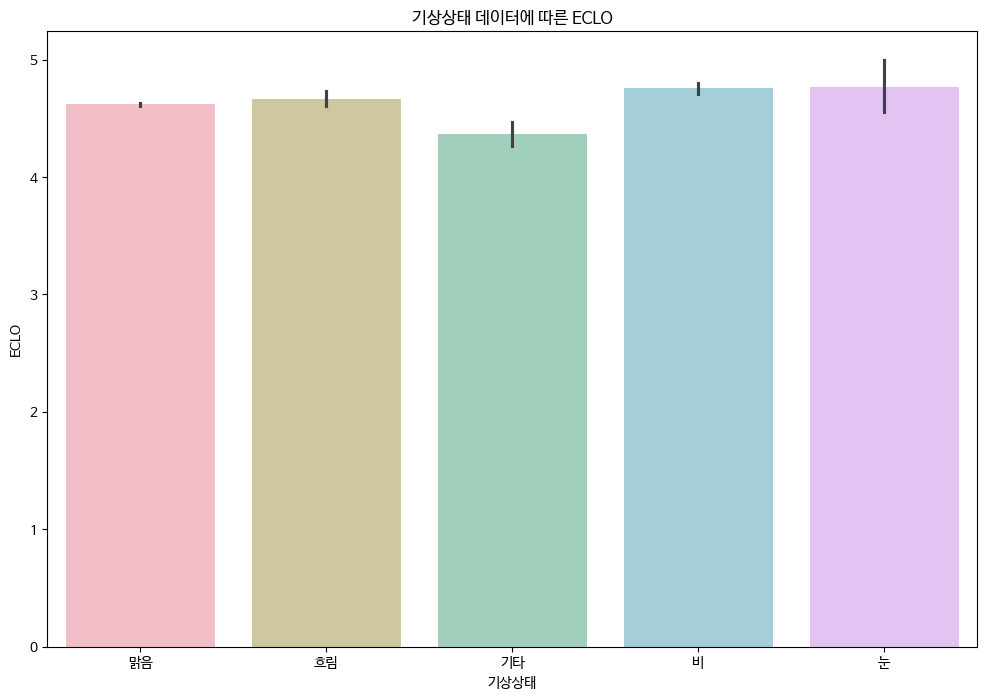

In [98]:
import matplotlib.pyplot as plt
import random
import seaborn as sns
from matplotlib import rc
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(12, 8))
sns.barplot(x='기상상태', y='ECLO', data=concatenated_df, alpha = 0.5, palette='husl')
plt.title('기상상태 데이터에 따른 ECLO')

plt.show()

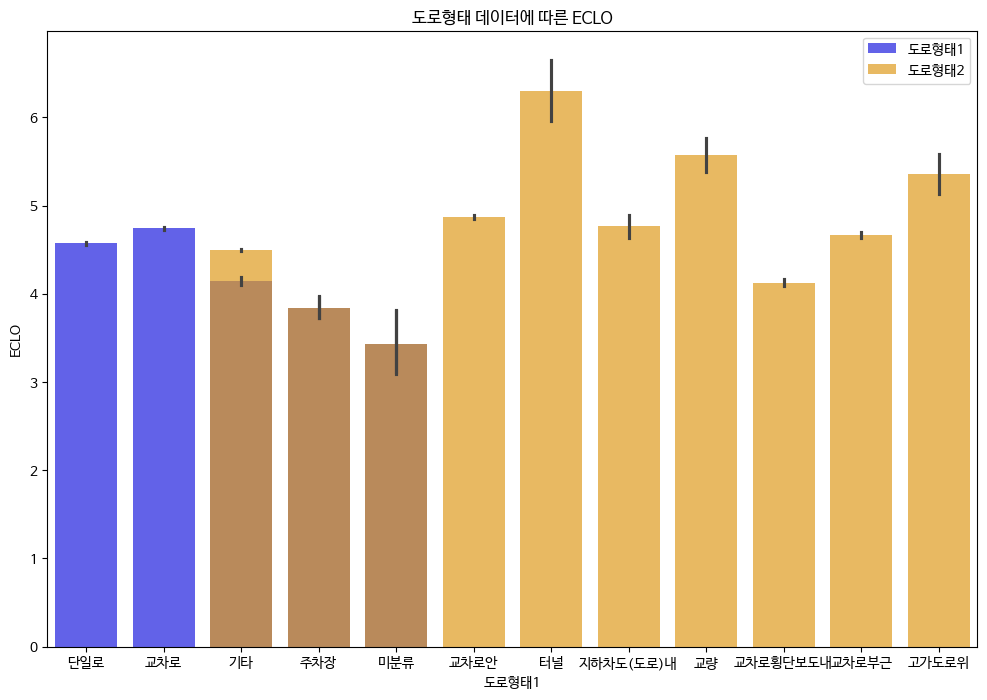

In [61]:
plt.figure(figsize=(12, 8))

# 도로 유형 1에 대한 사고율 플롯
sns.barplot(x='도로형태1', y='ECLO', data=concatenated_df, color='blue', alpha=0.7, label='도로형태1')

# 도로 유형 2에 대한 사고율 플롯
sns.barplot(x='도로형태2', y='ECLO', data=concatenated_df, color='orange', alpha=0.7, label='도로형태2')

plt.title('도로형태 데이터에 따른 ECLO')
plt.legend()
plt.show()

<ipython-input-97-637272fa4802>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=concatenated_df, x='holiday', y='ECLO',palette=['red','blue'])


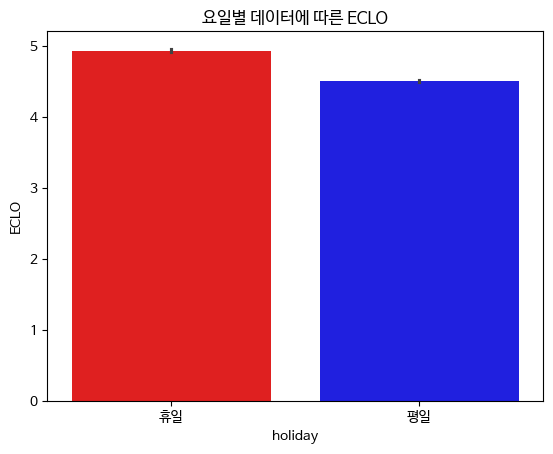

In [97]:
sns.barplot(data=concatenated_df, x='holiday', y='ECLO',palette=['red','blue'])
plt.title('요일별 데이터에 따른 ECLO')
plt.show()

<ipython-input-96-1a9c88a4db96>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='계절', y='ECLO', data=concatenated_df, palette=['aqua','lightcoral','lime','peru'])


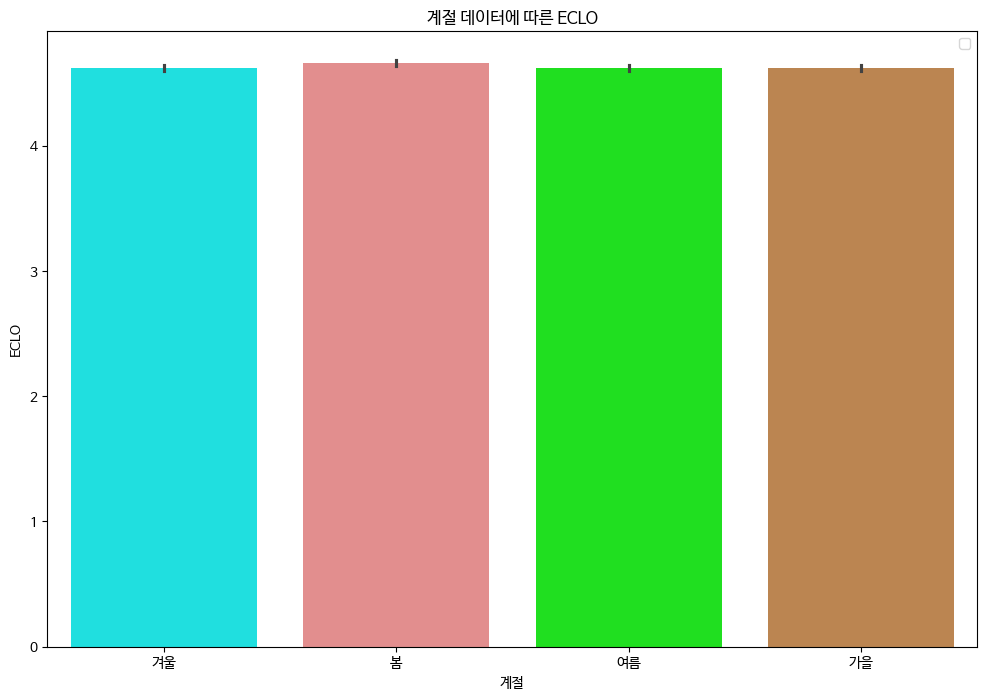

In [96]:
plt.figure(figsize=(12, 8))
sns.barplot(x='계절', y='ECLO', data=concatenated_df, palette=['aqua','lightcoral','lime','peru'])
plt.title('계절 데이터에 따른 ECLO')
plt.legend()
plt.show()

<ipython-input-100-ec57dbffb793>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='노면상태', y='ECLO', data=concatenated_df, palette='Paired')


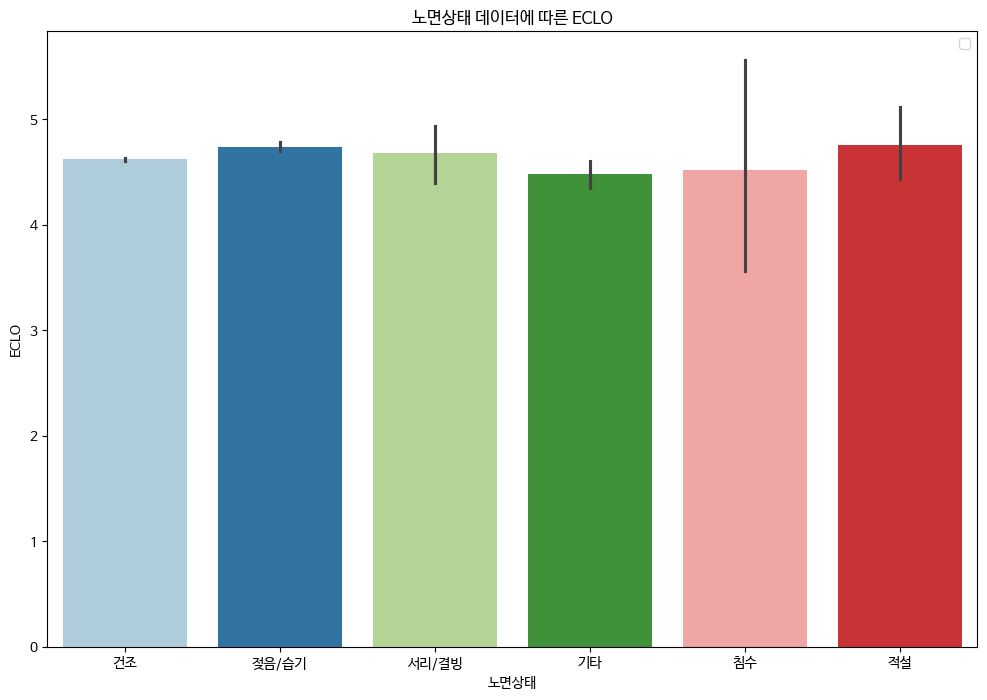

In [100]:
plt.figure(figsize=(12, 8))
sns.barplot(x='노면상태', y='ECLO', data=concatenated_df, palette='Paired')
plt.title('노면상태 데이터에 따른 ECLO')
plt.legend()
plt.show()

<ipython-input-99-2ace748070a2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='시', y='ECLO', data=concatenated_df, palette='hls')


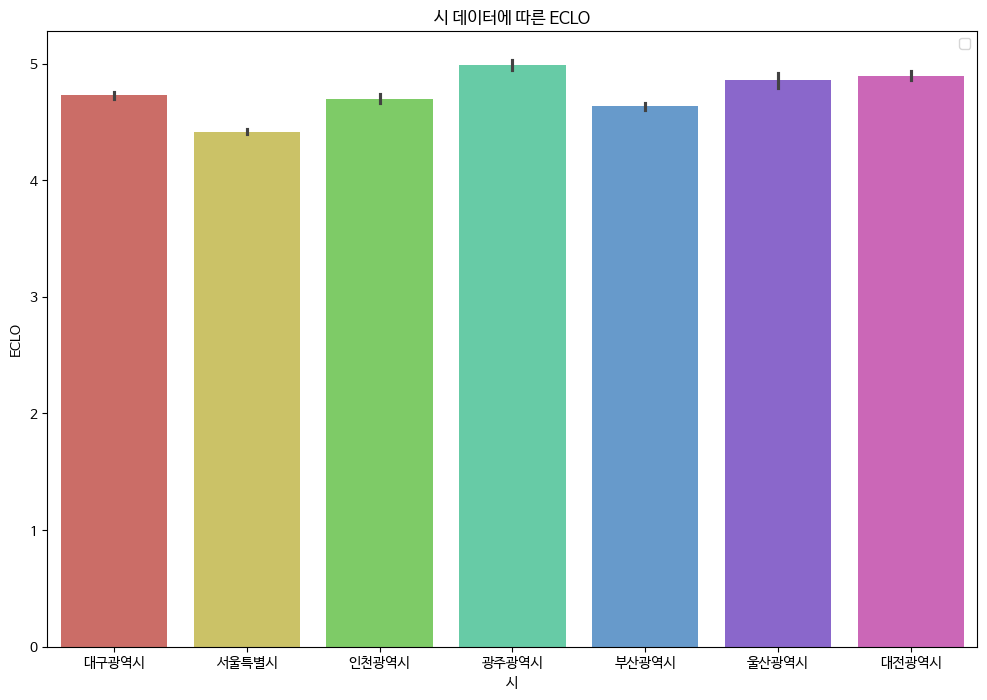

In [99]:
plt.figure(figsize=(12, 8))
sns.barplot(x='시', y='ECLO', data=concatenated_df, palette='hls')
plt.title('시 데이터에 따른 ECLO')
plt.legend()
plt.show()

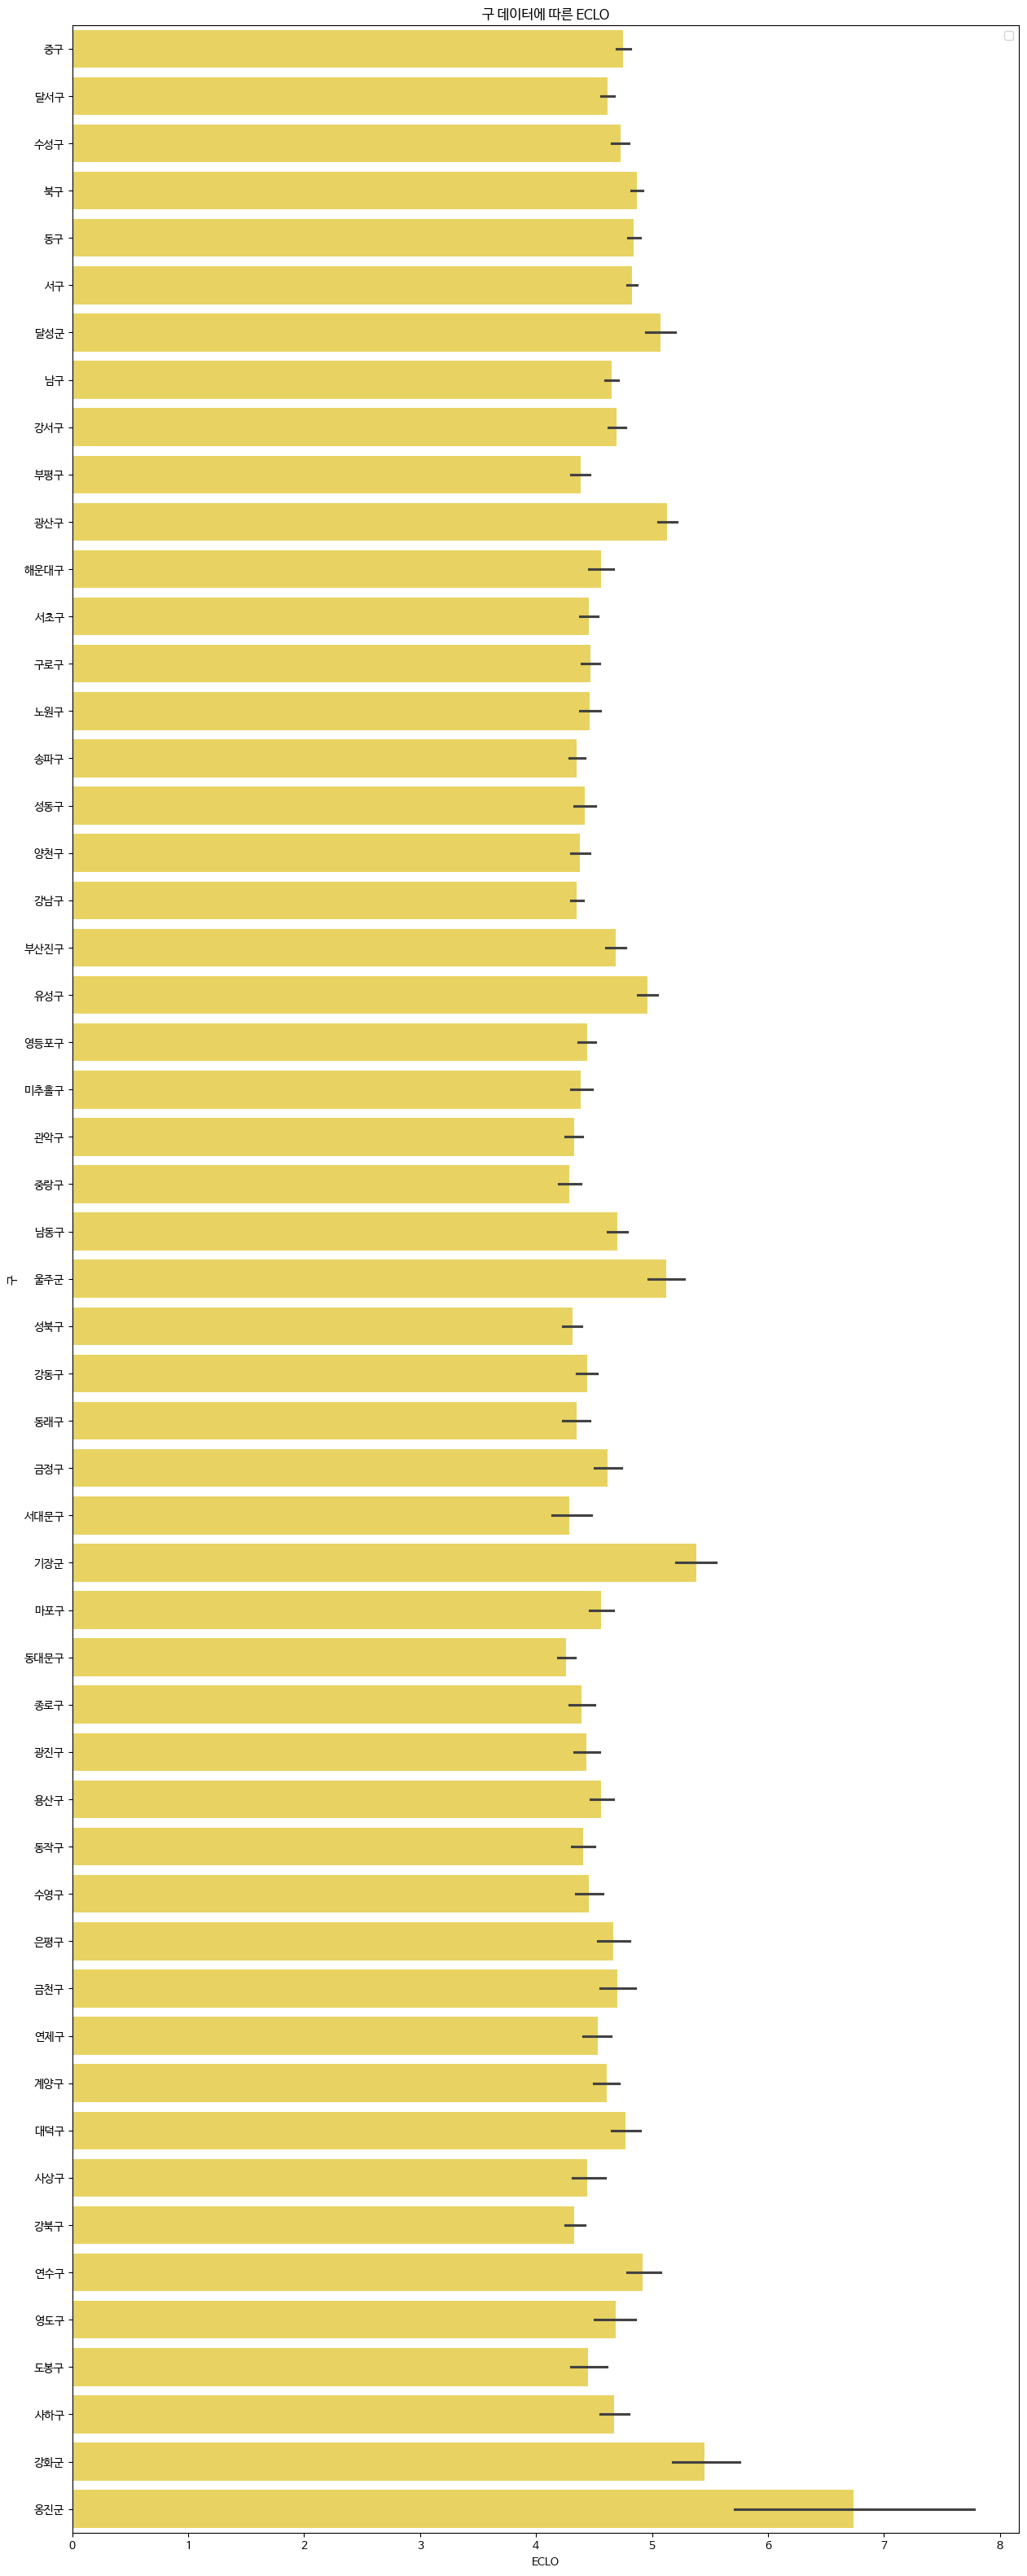

In [107]:
plt.figure(figsize=(15,40))
sns.barplot(x='ECLO', y='구', data=concatenated_df,color='gold',alpha=0.7, orient='h')
plt.title('구 데이터에 따른 ECLO')
plt.legend()
plt.show()

<ipython-input-110-4a46e833e83e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='시간구분', y='ECLO', data=concatenated_df, palette='Set1')


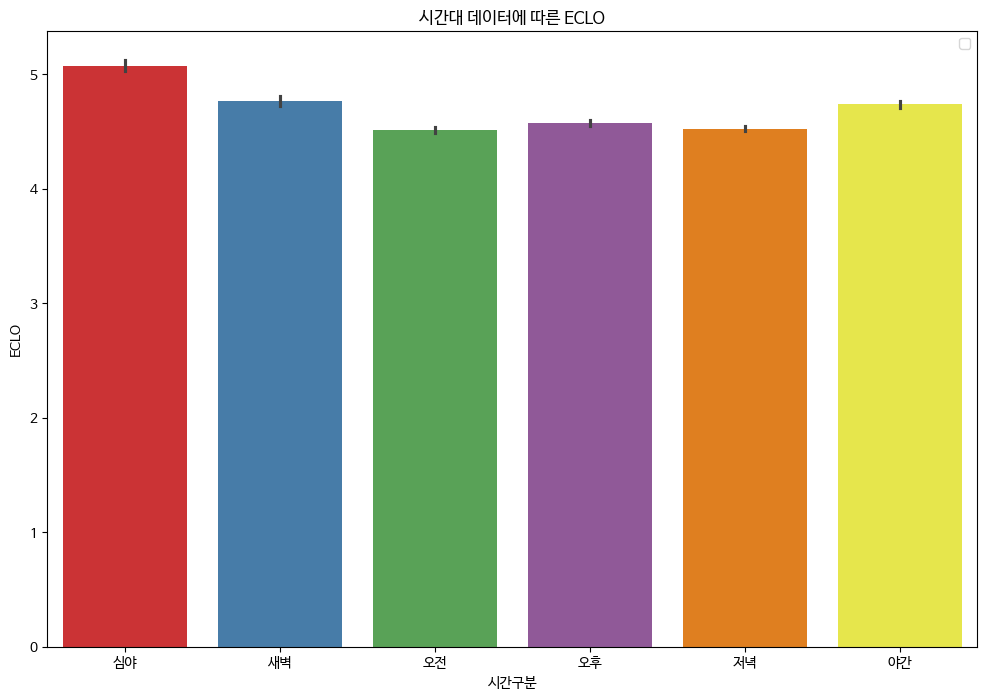

In [110]:
plt.figure(figsize=(12, 8))
sns.barplot(x='시간구분', y='ECLO', data=concatenated_df, palette='Set1')
plt.title('시간대 데이터에 따른 ECLO')
plt.legend()
plt.show()

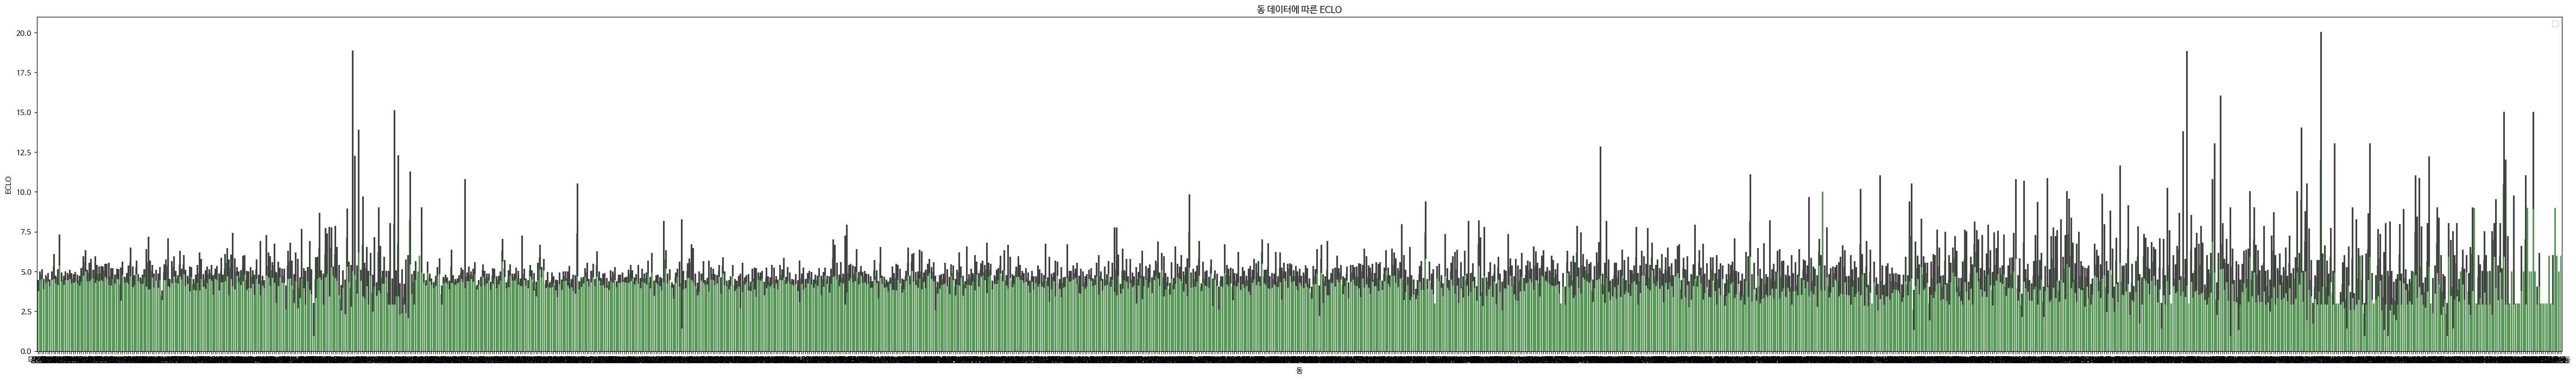

In [89]:
plt.figure(figsize=(60, 8))
# 동에 대한 사고율 플롯
sns.barplot(x='동', y='ECLO', data=concatenated_df, color='green', alpha=0.7)
plt.title('동 데이터에 따른 ECLO')

plt.legend()
plt.show()

#전처리 - 원핫인코딩

In [65]:
total_data = pd.concat([concatenated_df, test])
total_data = pd.get_dummies(total_data)

In [66]:
for c in total_data.columns:
    print(c)
print(len(total_data.columns))

사망자수
중상자수
경상자수
부상자수
ECLO
년도
월
시간
요일_금요일
요일_목요일
요일_수요일
요일_월요일
요일_일요일
요일_토요일
요일_화요일
기상상태_기타
기상상태_눈
기상상태_맑음
기상상태_비
기상상태_흐림
노면상태_건조
노면상태_기타
노면상태_서리/결빙
노면상태_적설
노면상태_젖음/습기
노면상태_침수
사고유형_차대사람
사고유형_차대차
사고유형_차량단독
시_광주광역시
시_대구광역시
시_대전광역시
시_부산광역시
시_서울특별시
시_울산광역시
시_인천광역시
구_강남구
구_강동구
구_강북구
구_강서구
구_강화군
구_계양구
구_관악구
구_광산구
구_광진구
구_구로구
구_금정구
구_금천구
구_기장군
구_남구
구_남동구
구_노원구
구_달서구
구_달성군
구_대덕구
구_도봉구
구_동구
구_동대문구
구_동래구
구_동작구
구_마포구
구_미추홀구
구_부산진구
구_부평구
구_북구
구_사상구
구_사하구
구_서구
구_서대문구
구_서초구
구_성동구
구_성북구
구_송파구
구_수성구
구_수영구
구_양천구
구_연수구
구_연제구
구_영도구
구_영등포구
구_옹진군
구_용산구
구_울주군
구_유성구
구_은평구
구_종로구
구_중구
구_중랑구
구_해운대구
동_가대동
동_가락동
동_가리봉동
동_가산동
동_가수원동
동_가야동
동_가양동
동_가오동
동_가장동
동_가정동
동_가좌동
동_가창면
동_가천동
동_가회동
동_각산동
동_각화동
동_간석동
동_갈마동
동_갈산동
동_갈월동
동_갈전동
동_갈현동
동_감만동
동_감삼동
동_감전동
동_감천동
동_갑동
동_강동동
동_강일동
동_강화읍
동_개금동
동_개봉동
동_개포동
동_개화동
동_거여동
동_거제동
동_검단동
동_검사동
동_검암동
동_견지동
동_경동
동_경서동
동_경운동
동_계동
동_계림동
동_계산동
동_계산동1가
동_계산동2가
동_고덕동
동_고룡동
동_고모동
동_고사동
동_고성동1가
동_고성동2가
동_고성동3가
동_고잔동
동_고척동
동_공덕동
동_공릉동
동_공촌동
동_공평동
동_공항동
동_과해동
동_관교동
동_관동1가
동_관동2가
동_관동3가
동_관수동
동_

In [67]:
train_data = total_data[~total_data['ECLO'].isnull()]
test_data = total_data[total_data['ECLO'].isnull()]

In [68]:
test_data = test_data.drop(['사망자수','중상자수','경상자수','부상자수','ECLO'], axis=1)

In [69]:
train_data

,사망자수,중상자수,경상자수,부상자수,ECLO,년도,월,시간,요일_금요일,요일_목요일,...,시간구분_새벽,시간구분_심야,시간구분_야간,시간구분_오전,시간구분_오후,시간구분_저녁,계절_가을,계절_겨울,계절_봄,계절_여름
0,0.0,1.0,0.0,0.0,5.0,2019,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0.0,0.0,1.0,0.0,3.0,2019,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0.0,0.0,1.0,0.0,3.0,2019,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0.0,1.0,0.0,0.0,5.0,2019,1,2,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.0,0.0,1.0,0.0,3.0,2019,1,4,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,0.0,0.0,1.0,0.0,3.0,2021,12,23,1,0,...,0,0,1,0,0,0,0,1,0,0
602769,0.0,1.0,0.0,0.0,5.0,2021,12,23,1,0,...,0,0,1,0,0,0,0,1,0,0
602770,0.0,1.0,1.0,0.0,8.0,2021,12,23,1,0,...,0,0,1,0,0,0,0,1,0,0
602771,0.0,0.0,2.0,0.0,6.0,2021,12,23,1,0,...,0,0,1,0,0,0,0,1,0,0


In [70]:
test_data

,년도,월,시간,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,...,시간구분_새벽,시간구분_심야,시간구분_야간,시간구분_오전,시간구분_오후,시간구분_저녁,계절_가을,계절_겨울,계절_봄,계절_여름
0,2022,1,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,2022,1,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,2022,1,4,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,2022,1,4,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,2022,1,6,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,2022,12,18,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
10959,2022,12,18,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
10960,2022,12,20,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
10961,2022,12,20,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [71]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267300 entries, 0 to 602772
Columns: 1399 entries, 사망자수 to 계절_여름
dtypes: float64(5), int64(3), uint8(1391)
memory usage: 372.9 MB


#AutoML을 이용한 하이퍼파라마터 튜닝

In [ ]:
!pip install optuna

In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error as msle


label값 분리

In [ ]:
y1=train_data[['ECLO']]
y2=train_data[['사망자수']]
y3=train_data[['중상자수']]
y4=train_data[['경상자수']]
y5=train_data[['부상자수']]
X=train_data.drop(columns=['사망자수','중상자수','경상자수','부상자수','ECLO'])

훈련,테스트(검증)셋 분리

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size=0.2, random_state=42)

XGBRegressor

In [ ]:
def objective(trial: Trial):
    params_xgb={
        'random_state':42,
        'max_depth':trial.suggest_int('max_depth',3,10),                        #트리의 최대 깊이 3~10
        'learning_rate':trial.suggest_float('learning_rate',0.0001,0.1),        #학습률 0.0001~0.1
        'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
        'reg_alpha':trial.suggest_float('reg_alpha',0.01,1.0),                  #L1규제
        'reg_lambda':trial.suggest_float('reg_lambda',0.01,1.0),                #L2규제
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),                #학습 시 사용할 훈련 데이터의 비율
        'eta': trial.suggest_float('eta', 0.007, 0.013),                        #부스팅 각 단계에서 사용되는 축소 비율
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),  #트리 구성하는데 사용할 특성의 비율
    }
    model=XGBRegressor(**params_xgb,n_jobs=-1)
    best_xgb=model.fit(X_train,y_train, eval_set=[(X_test,y_test)],eval_metric='rmsle',early_stopping_rounds=100)

    cgb_pred = model.predict(X_test)
    loss=msle(y_test,cgb_pred)

    return np.sqrt(loss)

In [ ]:
sampler = TPESampler(seed=42)
study1 = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study1.optimize(objective, n_trials=10)
best_xgb_model=XGBRegressor(**study1.best_trial.params,n_jobs=-1)
best_xgb_model.fit(X_train,y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=100, eval_metric='rmsle',verbose=False)
print("Best Score:", study1.best_value)
print("Best trial:", study1.best_trial.params)

[I 2024-03-05 01:14:21,274] A new study created in memory with name: xgb_parameter_opt
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmsle:0.44127
[1]	validation_0-rmsle:0.44024
[2]	validation_0-rmsle:0.43945
[3]	validation_0-rmsle:0.43872
[4]	validation_0-rmsle:0.43816
[5]	validation_0-rmsle:0.43766
[6]	validation_0-rmsle:0.43727
[7]	validation_0-rmsle:0.43692
[8]	validation_0-rmsle:0.43669
[9]	validation_0-rmsle:0.43645
[10]	validation_0-rmsle:0.43630
[11]	validation_0-rmsle:0.43617
[12]	validation_0-rmsle:0.43603
[13]	validation_0-rmsle:0.43591
[14]	validation_0-rmsle:0.43581
[15]	validation_0-rmsle:0.43566
[16]	validation_0-rmsle:0.43563
[17]	validation_0-rmsle:0.43553
[18]	validation_0-rmsle:0.43546
[19]	validation_0-rmsle:0.43538
[20]	validation_0-rmsle:0.43532
[21]	validation_0-rmsle:0.43529
[22]	validation_0-rmsle:0.43524
[23]	validation_0-rmsle:0.43519
[24]	validation_0-rmsle:0.43518
[25]	validation_0-rmsle:0.43517
[26]	validation_0-rmsle:0.43510
[27]	validation_0-rmsle:0.43505
[28]	validation_0-rmsle:0.43504
[29]	validation_0-rmsle:0.43506
[30]	validation_0-rmsle:0.43505
[31]	validation_0-

[I 2024-03-05 01:21:58,668] Trial 0 finished with value: 0.4344659675987801 and parameters: {'max_depth': 5, 'learning_rate': 0.09507635921035062, 'n_estimators': 800, 'reg_alpha': 0.6026718993550663, 'reg_lambda': 0.16445845403801215, 'subsample': 0.7467983561008608, 'eta': 0.007348501673009197, 'colsample_bytree': 0.9197056874649611}. Best is trial 0 with value: 0.4344659675987801.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is 

[0]	validation_0-rmsle:0.44158
[1]	validation_0-rmsle:0.44116
[2]	validation_0-rmsle:0.44043
[3]	validation_0-rmsle:0.43972
[4]	validation_0-rmsle:0.43917
[5]	validation_0-rmsle:0.43858
[6]	validation_0-rmsle:0.43814
[7]	validation_0-rmsle:0.43774
[8]	validation_0-rmsle:0.43740
[9]	validation_0-rmsle:0.43709
[10]	validation_0-rmsle:0.43682
[11]	validation_0-rmsle:0.43655
[12]	validation_0-rmsle:0.43636
[13]	validation_0-rmsle:0.43614
[14]	validation_0-rmsle:0.43599
[15]	validation_0-rmsle:0.43580
[16]	validation_0-rmsle:0.43567
[17]	validation_0-rmsle:0.43557
[18]	validation_0-rmsle:0.43549
[19]	validation_0-rmsle:0.43538
[20]	validation_0-rmsle:0.43531
[21]	validation_0-rmsle:0.43526
[22]	validation_0-rmsle:0.43520
[23]	validation_0-rmsle:0.43515
[24]	validation_0-rmsle:0.43509
[25]	validation_0-rmsle:0.43506
[26]	validation_0-rmsle:0.43502
[27]	validation_0-rmsle:0.43499
[28]	validation_0-rmsle:0.43496
[29]	validation_0-rmsle:0.43493
[30]	validation_0-rmsle:0.43492
[31]	validation_0-

[I 2024-03-05 01:25:41,429] Trial 1 finished with value: 0.4341972597454927 and parameters: {'max_depth': 7, 'learning_rate': 0.07083645052182495, 'n_estimators': 100, 'reg_alpha': 0.9702107536403743, 'reg_lambda': 0.8341182143924175, 'subsample': 0.7637017332034828, 'eta': 0.008090949803242604, 'colsample_bytree': 0.5100427059120604}. Best is trial 1 with value: 0.4341972597454927.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is d

[0]	validation_0-rmsle:0.44188
[1]	validation_0-rmsle:0.44159
[2]	validation_0-rmsle:0.44099
[3]	validation_0-rmsle:0.44043
[4]	validation_0-rmsle:0.43996
[5]	validation_0-rmsle:0.43948
[6]	validation_0-rmsle:0.43909
[7]	validation_0-rmsle:0.43876
[8]	validation_0-rmsle:0.43839
[9]	validation_0-rmsle:0.43811
[10]	validation_0-rmsle:0.43785
[11]	validation_0-rmsle:0.43758
[12]	validation_0-rmsle:0.43741
[13]	validation_0-rmsle:0.43718
[14]	validation_0-rmsle:0.43702
[15]	validation_0-rmsle:0.43681
[16]	validation_0-rmsle:0.43667
[17]	validation_0-rmsle:0.43656
[18]	validation_0-rmsle:0.43644
[19]	validation_0-rmsle:0.43632
[20]	validation_0-rmsle:0.43624
[21]	validation_0-rmsle:0.43615
[22]	validation_0-rmsle:0.43609
[23]	validation_0-rmsle:0.43600
[24]	validation_0-rmsle:0.43596
[25]	validation_0-rmsle:0.43593
[26]	validation_0-rmsle:0.43585
[27]	validation_0-rmsle:0.43580
[28]	validation_0-rmsle:0.43574
[29]	validation_0-rmsle:0.43571
[30]	validation_0-rmsle:0.43565
[31]	validation_0-

[I 2024-03-05 01:39:09,743] Trial 2 finished with value: 0.43417864932000805 and parameters: {'max_depth': 5, 'learning_rate': 0.05252316752006057, 'n_estimators': 500, 'reg_alpha': 0.2983168487960615, 'reg_lambda': 0.6157343657751557, 'subsample': 0.7418481581956126, 'eta': 0.008752867891211309, 'colsample_bytree': 0.619817105976215}. Best is trial 2 with value: 0.43417864932000805.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is 

[0]	validation_0-rmsle:0.44163
[1]	validation_0-rmsle:0.44117
[2]	validation_0-rmsle:0.44038
[3]	validation_0-rmsle:0.43959
[4]	validation_0-rmsle:0.43903
[5]	validation_0-rmsle:0.43847
[6]	validation_0-rmsle:0.43801
[7]	validation_0-rmsle:0.43765
[8]	validation_0-rmsle:0.43732
[9]	validation_0-rmsle:0.43703
[10]	validation_0-rmsle:0.43677
[11]	validation_0-rmsle:0.43653
[12]	validation_0-rmsle:0.43636
[13]	validation_0-rmsle:0.43619
[14]	validation_0-rmsle:0.43605
[15]	validation_0-rmsle:0.43588
[16]	validation_0-rmsle:0.43575
[17]	validation_0-rmsle:0.43568
[18]	validation_0-rmsle:0.43563
[19]	validation_0-rmsle:0.43554
[20]	validation_0-rmsle:0.43549
[21]	validation_0-rmsle:0.43543
[22]	validation_0-rmsle:0.43538
[23]	validation_0-rmsle:0.43533
[24]	validation_0-rmsle:0.43529
[25]	validation_0-rmsle:0.43525
[26]	validation_0-rmsle:0.43517
[27]	validation_0-rmsle:0.43513
[28]	validation_0-rmsle:0.43508
[29]	validation_0-rmsle:0.43506
[30]	validation_0-rmsle:0.43502
[31]	validation_0-

[I 2024-03-05 01:46:05,840] Trial 3 finished with value: 0.43442688555451187 and parameters: {'max_depth': 6, 'learning_rate': 0.07853907854316207, 'n_estimators': 200, 'reg_alpha': 0.5190920940294755, 'reg_lambda': 0.596490423173422, 'subsample': 0.7139351238159993, 'eta': 0.01064526911140863, 'colsample_bytree': 0.502314474212375}. Best is trial 2 with value: 0.43417864932000805.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is de

[0]	validation_0-rmsle:0.44154
[1]	validation_0-rmsle:0.44119
[2]	validation_0-rmsle:0.44041
[3]	validation_0-rmsle:0.43968
[4]	validation_0-rmsle:0.43919
[5]	validation_0-rmsle:0.43866
[6]	validation_0-rmsle:0.43827
[7]	validation_0-rmsle:0.43790
[8]	validation_0-rmsle:0.43758
[9]	validation_0-rmsle:0.43734
[10]	validation_0-rmsle:0.43714
[11]	validation_0-rmsle:0.43702
[12]	validation_0-rmsle:0.43690
[13]	validation_0-rmsle:0.43685
[14]	validation_0-rmsle:0.43675
[15]	validation_0-rmsle:0.43660
[16]	validation_0-rmsle:0.43658
[17]	validation_0-rmsle:0.43649
[18]	validation_0-rmsle:0.43649
[19]	validation_0-rmsle:0.43641
[20]	validation_0-rmsle:0.43632
[21]	validation_0-rmsle:0.43633
[22]	validation_0-rmsle:0.43626
[23]	validation_0-rmsle:0.43619
[24]	validation_0-rmsle:0.43621
[25]	validation_0-rmsle:0.43616
[26]	validation_0-rmsle:0.43609
[27]	validation_0-rmsle:0.43605
[28]	validation_0-rmsle:0.43601
[29]	validation_0-rmsle:0.43601
[30]	validation_0-rmsle:0.43597
[31]	validation_0-

[I 2024-03-05 02:00:49,050] Trial 4 finished with value: 0.4341566370510967 and parameters: {'max_depth': 3, 'learning_rate': 0.094893665171608, 'n_estimators': 1000, 'reg_alpha': 0.8103133746352965, 'reg_lambda': 0.31156763148163696, 'subsample': 0.7293016342019151, 'eta': 0.011105398159072941, 'colsample_bytree': 0.6640914962437607}. Best is trial 4 with value: 0.4341566370510967.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is d

[0]	validation_0-rmsle:0.44204
[1]	validation_0-rmsle:0.44184
[2]	validation_0-rmsle:0.44135
[3]	validation_0-rmsle:0.44085
[4]	validation_0-rmsle:0.44042
[5]	validation_0-rmsle:0.44001
[6]	validation_0-rmsle:0.43966
[7]	validation_0-rmsle:0.43934
[8]	validation_0-rmsle:0.43905
[9]	validation_0-rmsle:0.43877
[10]	validation_0-rmsle:0.43854
[11]	validation_0-rmsle:0.43834
[12]	validation_0-rmsle:0.43815
[13]	validation_0-rmsle:0.43796
[14]	validation_0-rmsle:0.43783
[15]	validation_0-rmsle:0.43765
[16]	validation_0-rmsle:0.43753
[17]	validation_0-rmsle:0.43741
[18]	validation_0-rmsle:0.43734
[19]	validation_0-rmsle:0.43724
[20]	validation_0-rmsle:0.43717
[21]	validation_0-rmsle:0.43707
[22]	validation_0-rmsle:0.43702
[23]	validation_0-rmsle:0.43695
[24]	validation_0-rmsle:0.43687
[25]	validation_0-rmsle:0.43680
[26]	validation_0-rmsle:0.43674
[27]	validation_0-rmsle:0.43669
[28]	validation_0-rmsle:0.43666
[29]	validation_0-rmsle:0.43660
[30]	validation_0-rmsle:0.43657
[31]	validation_0-

[I 2024-03-05 02:04:35,624] Trial 5 finished with value: 0.4352106701971594 and parameters: {'max_depth': 3, 'learning_rate': 0.0495681733201159, 'n_estimators': 100, 'reg_alpha': 0.9102271980579942, 'reg_lambda': 0.26619218178401677, 'subsample': 0.8987566853061946, 'eta': 0.008870266456536467, 'colsample_bytree': 0.7120408127066865}. Best is trial 4 with value: 0.4341566370510967.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is d

[0]	validation_0-rmsle:0.44232
[1]	validation_0-rmsle:0.44203
[2]	validation_0-rmsle:0.44176
[3]	validation_0-rmsle:0.44150
[4]	validation_0-rmsle:0.44125
[5]	validation_0-rmsle:0.44100
[6]	validation_0-rmsle:0.44076
[7]	validation_0-rmsle:0.44053
[8]	validation_0-rmsle:0.44032
[9]	validation_0-rmsle:0.44011
[10]	validation_0-rmsle:0.43992
[11]	validation_0-rmsle:0.43973
[12]	validation_0-rmsle:0.43954
[13]	validation_0-rmsle:0.43937
[14]	validation_0-rmsle:0.43919
[15]	validation_0-rmsle:0.43903
[16]	validation_0-rmsle:0.43887
[17]	validation_0-rmsle:0.43872
[18]	validation_0-rmsle:0.43858
[19]	validation_0-rmsle:0.43844
[20]	validation_0-rmsle:0.43830
[21]	validation_0-rmsle:0.43818
[22]	validation_0-rmsle:0.43806
[23]	validation_0-rmsle:0.43794
[24]	validation_0-rmsle:0.43783
[25]	validation_0-rmsle:0.43771
[26]	validation_0-rmsle:0.43761
[27]	validation_0-rmsle:0.43751
[28]	validation_0-rmsle:0.43741
[29]	validation_0-rmsle:0.43732
[30]	validation_0-rmsle:0.43722
[31]	validation_0-

[I 2024-03-05 02:16:29,869] Trial 6 finished with value: 0.43448916971889695 and parameters: {'max_depth': 7, 'learning_rate': 0.018566960107000152, 'n_estimators': 1000, 'reg_alpha': 0.7773814951275034, 'reg_lambda': 0.9401039521485473, 'subsample': 0.9684482051282947, 'eta': 0.01058739987286651, 'colsample_bytree': 0.9531245410138701}. Best is trial 4 with value: 0.4341566370510967.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is

[0]	validation_0-rmsle:0.44238
[1]	validation_0-rmsle:0.44229
[2]	validation_0-rmsle:0.44208
[3]	validation_0-rmsle:0.44185
[4]	validation_0-rmsle:0.44166
[5]	validation_0-rmsle:0.44146
[6]	validation_0-rmsle:0.44127
[7]	validation_0-rmsle:0.44111
[8]	validation_0-rmsle:0.44092
[9]	validation_0-rmsle:0.44075
[10]	validation_0-rmsle:0.44059
[11]	validation_0-rmsle:0.44041
[12]	validation_0-rmsle:0.44029
[13]	validation_0-rmsle:0.44014
[14]	validation_0-rmsle:0.44001
[15]	validation_0-rmsle:0.43986
[16]	validation_0-rmsle:0.43972
[17]	validation_0-rmsle:0.43959
[18]	validation_0-rmsle:0.43946
[19]	validation_0-rmsle:0.43934
[20]	validation_0-rmsle:0.43922
[21]	validation_0-rmsle:0.43911
[22]	validation_0-rmsle:0.43900
[23]	validation_0-rmsle:0.43890
[24]	validation_0-rmsle:0.43881
[25]	validation_0-rmsle:0.43872
[26]	validation_0-rmsle:0.43864
[27]	validation_0-rmsle:0.43861
[28]	validation_0-rmsle:0.43853
[29]	validation_0-rmsle:0.43848
[30]	validation_0-rmsle:0.43842
[31]	validation_0-

[I 2024-03-05 02:20:17,709] Trial 7 finished with value: 0.4362751259071914 and parameters: {'max_depth': 3, 'learning_rate': 0.019678687955672604, 'n_estimators': 100, 'reg_alpha': 0.3320770274556317, 'reg_lambda': 0.3947905167925872, 'subsample': 0.7814047095321688, 'eta': 0.011972425054911575, 'colsample_bytree': 0.6140519960161536}. Best is trial 4 with value: 0.4341566370510967.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is 

[0]	validation_0-rmsle:0.44188
[1]	validation_0-rmsle:0.44158
[2]	validation_0-rmsle:0.44101
[3]	validation_0-rmsle:0.44044
[4]	validation_0-rmsle:0.44000
[5]	validation_0-rmsle:0.43953
[6]	validation_0-rmsle:0.43915
[7]	validation_0-rmsle:0.43884
[8]	validation_0-rmsle:0.43851
[9]	validation_0-rmsle:0.43824
[10]	validation_0-rmsle:0.43797
[11]	validation_0-rmsle:0.43772
[12]	validation_0-rmsle:0.43753
[13]	validation_0-rmsle:0.43728
[14]	validation_0-rmsle:0.43710
[15]	validation_0-rmsle:0.43691
[16]	validation_0-rmsle:0.43676
[17]	validation_0-rmsle:0.43659
[18]	validation_0-rmsle:0.43646
[19]	validation_0-rmsle:0.43634
[20]	validation_0-rmsle:0.43625
[21]	validation_0-rmsle:0.43617
[22]	validation_0-rmsle:0.43607
[23]	validation_0-rmsle:0.43598
[24]	validation_0-rmsle:0.43590
[25]	validation_0-rmsle:0.43582
[26]	validation_0-rmsle:0.43576
[27]	validation_0-rmsle:0.43569
[28]	validation_0-rmsle:0.43565
[29]	validation_0-rmsle:0.43560
[30]	validation_0-rmsle:0.43553
[31]	validation_0-

[I 2024-03-05 02:27:10,578] Trial 8 finished with value: 0.43416789955647334 and parameters: {'max_depth': 5, 'learning_rate': 0.05431533870750903, 'n_estimators': 200, 'reg_alpha': 0.8041750109464992, 'reg_lambda': 0.08380513724297312, 'subsample': 0.9960660809801551, 'eta': 0.011633468615779945, 'colsample_bytree': 0.5192294089205034}. Best is trial 4 with value: 0.4341566370510967.
<ipython-input-64-25e3329bee13>:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators':trial.suggest_int('n_estimators',100,1000,100),          #트리 개수 100~1000 100단위
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is

[0]	validation_0-rmsle:0.44174
[1]	validation_0-rmsle:0.44141
[2]	validation_0-rmsle:0.44084
[3]	validation_0-rmsle:0.44011
[4]	validation_0-rmsle:0.43966
[5]	validation_0-rmsle:0.43947
[6]	validation_0-rmsle:0.43904
[7]	validation_0-rmsle:0.43868
[8]	validation_0-rmsle:0.43832
[9]	validation_0-rmsle:0.43802
[10]	validation_0-rmsle:0.43775
[11]	validation_0-rmsle:0.43756
[12]	validation_0-rmsle:0.43741
[13]	validation_0-rmsle:0.43723
[14]	validation_0-rmsle:0.43714
[15]	validation_0-rmsle:0.43696
[16]	validation_0-rmsle:0.43690
[17]	validation_0-rmsle:0.43681
[18]	validation_0-rmsle:0.43677
[19]	validation_0-rmsle:0.43670
[20]	validation_0-rmsle:0.43666
[21]	validation_0-rmsle:0.43660
[22]	validation_0-rmsle:0.43653
[23]	validation_0-rmsle:0.43646
[24]	validation_0-rmsle:0.43642
[25]	validation_0-rmsle:0.43635
[26]	validation_0-rmsle:0.43629
[27]	validation_0-rmsle:0.43627
[28]	validation_0-rmsle:0.43623
[29]	validation_0-rmsle:0.43622
[30]	validation_0-rmsle:0.43619
[31]	validation_0-

[I 2024-03-05 02:40:23,208] Trial 9 finished with value: 0.43433863985023297 and parameters: {'max_depth': 3, 'learning_rate': 0.08156459670263794, 'n_estimators': 800, 'reg_alpha': 0.7317170963605775, 'reg_lambda': 0.7735576432190863, 'subsample': 0.7222133955202271, 'eta': 0.009150794371265637, 'colsample_bytree': 0.4695214357150779}. Best is trial 4 with value: 0.4341566370510967.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Score: 0.4341566370510967
Best trial: {'max_depth': 3, 'learning_rate': 0.094893665171608, 'n_estimators': 1000, 'reg_alpha': 0.8103133746352965, 'reg_lambda': 0.31156763148163696, 'subsample': 0.7293016342019151, 'eta': 0.011105398159072941, 'colsample_bytree': 0.6640914962437607}


In [ ]:
import joblib

# XGBoost 모델 저장
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')


['best_xgb_model.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study1)

In [ ]:
#파라미터들관의 관계
optuna.visualization.plot_parallel_coordinate(study1)

lightlgbm

In [ ]:
from lightgbm import LGBMRegressor, early_stopping

In [ ]:
def objective2(trial:Trial):
    params_lgb ={
        'random_state':42,
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True),   #최대 잎의 수
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),     #학습률
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000,100),           #트리 개수
        'subsample': trial.suggest_loguniform('subsample', 0.4,1),                  #학습 시 사용할 훈련 데이터의 비율
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),      #트리를 구성하는 데 사용할 특성의 비율
        'reg_alpha':trial.suggest_float('reg_alpha',0.01,1.0),                      #L1규제
        'reg_lambda':trial.suggest_float('reg_lambda',0.01,1.0),                    #L2규제
        'max_depth': trial.suggest_int('max_depth',3, 10),                          #최대 깊이
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),        #리프 노드에서 필요핸 최소 샘플 개수
    }
    model=LGBMRegressor(**params_lgb,n_jobs=-1)
    best_lgbm=model.fit(X_train,y_train, eval_set=[(X_test,y_test)],eval_metric='rmsle', callbacks=[early_stopping(stopping_rounds=100)])

    lgbm_pred = model.predict(X_test)
    loss=msle(y_test,lgbm_pred)

    return np.sqrt(loss)


In [ ]:
sampler = TPESampler(seed=42)
study2 = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study2.optimize(objective2, n_trials=10)
best_lgbm_model = LGBMRegressor(**study2.best_trial.params,n_jobs=-1)
best_lgbm_model.fit(X_train,y_train, eval_set=[(X_test,y_test)],eval_metric='rmsle', callbacks=[early_stopping(stopping_rounds=100)])
print("Best Score:", study2.best_value)
print("Best trial:", study2.best_trial.params)

[I 2024-03-05 02:50:54,939] A new study created in memory with name: lgbm_parameter_opt
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 760
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's rmse: 3.00756


[I 2024-03-05 02:51:32,137] Trial 0 finished with value: 0.43427763071455167 and parameters: {'num_leaves': 17, 'learning_rate': 0.005061576888752304, 'n_estimators': 800, 'subsample': 0.6922933401417407, 'colsample_bytree': 0.4936111842654619, 'reg_alpha': 0.16443457513284063, 'reg_lambda': 0.06750277604651747, 'max_depth': 9, 'min_child_samples': 62}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1599
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 782
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2024-03-05 02:52:08,235] Trial 1 finished with value: 0.44261166442696137 and parameters: {'num_leaves': 152, 'learning_rate': 1.328944872286916e-08, 'n_estimators': 1000, 'subsample': 0.8576739569300319, 'colsample_bytree': 0.5274034664069657, 'reg_alpha': 0.19000671753502962, 'reg_lambda': 0.1915704647548995, 'max_depth': 5, 'min_child_samples': 55}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 974
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[700]	valid_0's rmse: 3.06381


[I 2024-03-05 02:52:36,378] Trial 2 finished with value: 0.44260674834383923 and parameters: {'num_leaves': 25, 'learning_rate': 5.589524205217922e-07, 'n_estimators': 700, 'subsample': 0.4545379819518452, 'colsample_bytree': 0.5752867891211308, 'reg_alpha': 0.37269822486075477, 'reg_lambda': 0.46150928437486555, 'max_depth': 9, 'min_child_samples': 24}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 671
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 3.06357


[I 2024-03-05 02:52:46,408] Trial 3 finished with value: 0.44256645279342927 and parameters: {'num_leaves': 43, 'learning_rate': 3.5849855803404713e-05, 'n_estimators': 100, 'subsample': 0.6979533481749362, 'colsample_bytree': 0.502314474212375, 'reg_alpha': 0.07440107705542671, 'reg_lambda': 0.9493966818808, 'max_depth': 10, 'min_child_samples': 82}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 926
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[700]	valid_0's rmse: 3.06383


[I 2024-03-05 02:53:11,275] Trial 4 finished with value: 0.4426115300276715 and parameters: {'num_leaves': 11, 'learning_rate': 3.855073690026179e-08, 'n_estimators': 700, 'subsample': 0.5987069208932017, 'colsample_bytree': 0.47322294090686734, 'reg_alpha': 0.5002251410101575, 'reg_lambda': 0.044044635904066216, 'max_depth': 10, 'min_child_samples': 29}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1341
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 653
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[600]	valid_0's rmse: 3.0638


[I 2024-03-05 02:53:44,868] Trial 5 finished with value: 0.4426058903897827 and parameters: {'num_leaves': 113, 'learning_rate': 7.417652034871823e-07, 'n_estimators': 600, 'subsample': 0.6601123904545768, 'colsample_bytree': 0.5109126733153162, 'reg_alpha': 0.9698887814869129, 'reg_lambda': 0.7773814951275034, 'max_depth': 10, 'min_child_samples': 90}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 666
[LightGBM] [Info] Start training from score 4.632730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2024-03-05 02:53:54,683] Trial 6 finished with value: 0.43972168984821636 and parameters: {'num_leaves': 74, 'learning_rate': 0.0033981724150106006, 'n_estimators': 100, 'subsample': 0.47868455315089947, 'colsample_bytree': 0.4271363733463229, 'reg_alpha': 0.3320770274556317, 'reg_lambda': 0.3947905167925872, 'max_depth': 5, 'min_child_samples': 84}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1983
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 974
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[600]	valid_0's rmse: 3.06381


[I 2024-03-05 02:54:18,957] Trial 7 finished with value: 0.44260760782315534 and parameters: {'num_leaves': 15, 'learning_rate': 4.848496183873288e-07, 'n_estimators': 600, 'subsample': 0.45513410343452926, 'colsample_bytree': 0.8813181884524238, 'reg_alpha': 0.08380513724297312, 'reg_lambda': 0.9870180672345121, 'max_depth': 9, 'min_child_samples': 24}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1349
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 657
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's rmse: 3.04587


[I 2024-03-05 02:54:34,787] Trial 8 finished with value: 0.4397605430350371 and parameters: {'num_leaves': 2, 'learning_rate': 0.0007812113973534924, 'n_estimators': 800, 'subsample': 0.7801194575432674, 'colsample_bytree': 0.8627622080115674, 'reg_alpha': 0.08330420521674946, 'reg_lambda': 0.3648810712588299, 'max_depth': 3, 'min_child_samples': 87}. Best is trial 0 with value: 0.43427763071455167.
<ipython-input-70-22fdc0749213>:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-70-22fdc0749213>:8: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-70-22fdc0749213>:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1655
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 810
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 3.06383


[I 2024-03-05 02:54:46,960] Trial 9 finished with value: 0.4426104454858959 and parameters: {'num_leaves': 88, 'learning_rate': 9.669146694016007e-07, 'n_estimators': 100, 'subsample': 0.5318783332418758, 'colsample_bytree': 0.5951099932160482, 'reg_alpha': 0.7323101165546835, 'reg_lambda': 0.641181896641661, 'max_depth': 10, 'min_child_samples': 50}. Best is trial 0 with value: 0.43427763071455167.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1549
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 757
[LightGBM] [Info] Start training from score 4.632730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's l2: 9.04528
Best Score: 0.43427763071455167
Best trial: {'num_leaves': 17, 'learning_rate': 0.005061576888752304, 'n_estimators': 800, 'subsample': 0.6922933401417407, 'colsample_bytree': 0.4936111842654619, 'reg_alpha': 0.16443457513284063, 'reg_lambda': 0.06750277604651747, 'max_depth': 9, 'min_child_samples': 62}


In [ ]:
joblib.dump(best_lgbm_model, 'best_lgbm_model.pkl')

['best_lgbm_model.pkl']

catboost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
def objective3(trial:Trial):
    params_cat ={
        'iterations':trial.suggest_int("iterations", 100, 1000,100),                            #부스팅 반복 횟수
        'od_wait':trial.suggest_int('od_wait', 500, 2300),                                      #조기 정지를 위한 반복 횟수
        'learning_rate' : trial.suggest_uniform('learning_rate',1e-8, 1),                       #학습률
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),                             #L2규제
        'subsample': trial.suggest_uniform('subsample',0.4,1),                                  #각 부스팅 단계에서 사용되는 훈련 데이터의 샘플링 비율
        'random_strength': trial.suggest_uniform('random_strength',10,50),                      #데이터 샘플의 무작위성을 조절
        'depth': trial.suggest_int('depth',1, 15),                                              #트리의 최대 깊이
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),                         #리프 노드에 필요한 최소 데이터 수
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),     #리프 노드의 추정 반복 횟수
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),   #부트스트랩 샘플링 온도
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),                 #각 트리 수준에서 특성을 샘플링하는 비율
    }
    model=CatBoostRegressor(**params_cat)
    best_cat=model.fit(X_train, y_train, eval_set=[(X_test,y_test)],early_stopping_rounds=100)

    cat_pred = model.predict(X_test)
    loss=msle(y_test,cat_pred)

    return np.sqrt(loss)


In [ ]:
sampler = TPESampler(seed=42)
study3 = optuna.create_study(
    study_name="cat_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study3.optimize(objective3, n_trials=10)
best_cat_model=CatBoostRegressor(**study3.best_trial.params)
best_cat_model.fit(X_train,y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=100,verbose=False)
print("Best Score:", study3.best_value)
print("Best trial:", study3.best_trial.params)

[I 2024-03-05 02:55:28,060] A new study created in memory with name: cat_parameter_opt
<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:7: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:8: FutureWarning:

suggest_uniform has been depre

0:	learn: 3.1941273	test: 3.0638830	best: 3.0638830 (0)	total: 209ms	remaining: 1m 23s
1:	learn: 3.1910938	test: 3.0602882	best: 3.0602882 (1)	total: 280ms	remaining: 55.8s
2:	learn: 3.1907747	test: 3.0601287	best: 3.0601287 (2)	total: 351ms	remaining: 46.5s
3:	learn: 3.1718068	test: 3.0406142	best: 3.0406142 (3)	total: 435ms	remaining: 43.1s
4:	learn: 3.1715726	test: 3.0402740	best: 3.0402740 (4)	total: 522ms	remaining: 41.3s
5:	learn: 3.1696364	test: 3.0384164	best: 3.0384164 (5)	total: 630ms	remaining: 41.3s
6:	learn: 3.1695703	test: 3.0383081	best: 3.0383081 (6)	total: 683ms	remaining: 38.3s
7:	learn: 3.1695489	test: 3.0382835	best: 3.0382835 (7)	total: 716ms	remaining: 35.1s
8:	learn: 3.1695445	test: 3.0382553	best: 3.0382553 (8)	total: 750ms	remaining: 32.6s
9:	learn: 3.1679726	test: 3.0363976	best: 3.0363976 (9)	total: 814ms	remaining: 31.7s
10:	learn: 3.1636122	test: 3.0318442	best: 3.0318442 (10)	total: 893ms	remaining: 31.6s
11:	learn: 3.1632988	test: 3.0315258	best: 3.031525

[I 2024-03-05 02:55:54,578] Trial 0 finished with value: 0.4357812453468696 and parameters: {'iterations': 400, 'od_wait': 2212, 'learning_rate': 0.7319939444914657, 'reg_lambda': 59.86585243311882, 'subsample': 0.4936111842654619, 'random_strength': 16.239780813448107, 'depth': 1, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 10, 'bagging_temperature': 6.79657809075816, 'colsample_bylevel': 0.41235069657748147}. Best is trial 0 with value: 0.4357812453468696.
<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

0:	learn: 3.1820236	test: 3.0515023	best: 3.0515023 (0)	total: 57.5ms	remaining: 57.4s
1:	learn: 3.1758064	test: 3.0448603	best: 3.0448603 (1)	total: 93.3ms	remaining: 46.6s
2:	learn: 3.1718014	test: 3.0406767	best: 3.0406767 (2)	total: 140ms	remaining: 46.6s
3:	learn: 3.1682939	test: 3.0370092	best: 3.0370092 (3)	total: 195ms	remaining: 48.5s
4:	learn: 3.1661019	test: 3.0349060	best: 3.0349060 (4)	total: 234ms	remaining: 46.5s
5:	learn: 3.1658512	test: 3.0346429	best: 3.0346429 (5)	total: 265ms	remaining: 44s
6:	learn: 3.1635880	test: 3.0322218	best: 3.0322218 (6)	total: 315ms	remaining: 44.6s
7:	learn: 3.1601526	test: 3.0289788	best: 3.0289788 (7)	total: 362ms	remaining: 44.9s
8:	learn: 3.1590111	test: 3.0278444	best: 3.0278444 (8)	total: 407ms	remaining: 44.8s
9:	learn: 3.1573710	test: 3.0264145	best: 3.0264145 (9)	total: 455ms	remaining: 45.1s
10:	learn: 3.1571279	test: 3.0261218	best: 3.0261218 (10)	total: 496ms	remaining: 44.6s
11:	learn: 3.1567884	test: 3.0258552	best: 3.0258552

[I 2024-03-05 02:56:17,988] Trial 1 finished with value: 0.4346464357752033 and parameters: {'iterations': 1000, 'od_wait': 1999, 'learning_rate': 0.21233911855488502, 'reg_lambda': 18.182504902460387, 'subsample': 0.5100427059120604, 'random_strength': 22.16968971838151, 'depth': 8, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 5, 'bagging_temperature': 2.801635158716261, 'colsample_bylevel': 0.4836963163912251}. Best is trial 1 with value: 0.4346464357752033.
<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

0:	learn: 3.1678927	test: 3.0366785	best: 3.0366785 (0)	total: 76.6ms	remaining: 22.9s
1:	learn: 3.1637775	test: 3.0326873	best: 3.0326873 (1)	total: 145ms	remaining: 21.7s
2:	learn: 3.1564555	test: 3.0253962	best: 3.0253962 (2)	total: 220ms	remaining: 21.7s
3:	learn: 3.1553786	test: 3.0242563	best: 3.0242563 (3)	total: 295ms	remaining: 21.8s
4:	learn: 3.1549470	test: 3.0241336	best: 3.0241336 (4)	total: 345ms	remaining: 20.4s
5:	learn: 3.1541635	test: 3.0232120	best: 3.0232120 (5)	total: 389ms	remaining: 19.1s
6:	learn: 3.1532161	test: 3.0227082	best: 3.0227082 (6)	total: 459ms	remaining: 19.2s
7:	learn: 3.1526310	test: 3.0225807	best: 3.0225807 (7)	total: 536ms	remaining: 19.6s
8:	learn: 3.1502138	test: 3.0205624	best: 3.0205624 (8)	total: 610ms	remaining: 19.7s
9:	learn: 3.1493742	test: 3.0197814	best: 3.0197814 (9)	total: 685ms	remaining: 19.9s
10:	learn: 3.1482569	test: 3.0186547	best: 3.0186547 (10)	total: 719ms	remaining: 18.9s
11:	learn: 3.1467008	test: 3.0179028	best: 3.017902

[I 2024-03-05 02:56:39,397] Trial 2 finished with value: 0.43481295888605714 and parameters: {'iterations': 300, 'od_wait': 1159, 'learning_rate': 0.45606998965633605, 'reg_lambda': 78.51759828754174, 'subsample': 0.5198042692950159, 'random_strength': 30.569377536544465, 'depth': 9, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.04809461967501574, 'colsample_bylevel': 0.43903095579116774}. Best is trial 1 with value: 0.4346464357752033.
<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

0:	learn: 3.1691205	test: 3.0385811	best: 3.0385811 (0)	total: 45.8ms	remaining: 45.8s
1:	learn: 3.1617108	test: 3.0319044	best: 3.0319044 (1)	total: 92.7ms	remaining: 46.3s
2:	learn: 3.1571690	test: 3.0271949	best: 3.0271949 (2)	total: 124ms	remaining: 41.3s
3:	learn: 3.1548987	test: 3.0255838	best: 3.0255838 (3)	total: 169ms	remaining: 42.1s
4:	learn: 3.1533935	test: 3.0237728	best: 3.0237728 (4)	total: 227ms	remaining: 45.1s
5:	learn: 3.1517894	test: 3.0226784	best: 3.0226784 (5)	total: 297ms	remaining: 49.2s
6:	learn: 3.1508730	test: 3.0215039	best: 3.0215039 (6)	total: 385ms	remaining: 54.6s
7:	learn: 3.1499222	test: 3.0206174	best: 3.0206174 (7)	total: 454ms	remaining: 56.3s
8:	learn: 3.1494992	test: 3.0203766	best: 3.0203766 (8)	total: 562ms	remaining: 1m 1s
9:	learn: 3.1483344	test: 3.0201368	best: 3.0201368 (9)	total: 675ms	remaining: 1m 6s
10:	learn: 3.1481597	test: 3.0198368	best: 3.0198368 (10)	total: 766ms	remaining: 1m 8s
11:	learn: 3.1473693	test: 3.0190801	best: 3.01908

[I 2024-03-05 02:56:53,643] Trial 3 finished with value: 0.4357681310839834 and parameters: {'iterations': 1000, 'od_wait': 2239, 'learning_rate': 0.8083973500324877, 'reg_lambda': 30.461383871199377, 'subsample': 0.45860326840383037, 'random_strength': 37.36932106048627, 'depth': 7, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.013726318898045875, 'colsample_bylevel': 0.9455922412472693}. Best is trial 1 with value: 0.4346464357752033.
<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

0:	learn: 3.1807374	test: 3.0500976	best: 3.0500976 (0)	total: 113ms	remaining: 33.6s
1:	learn: 3.1735142	test: 3.0442897	best: 3.0442897 (1)	total: 3.79s	remaining: 9m 24s
2:	learn: 3.1669331	test: 3.0374772	best: 3.0374772 (2)	total: 3.85s	remaining: 6m 21s
3:	learn: 3.1599077	test: 3.0310064	best: 3.0310064 (3)	total: 4.13s	remaining: 5m 5s
4:	learn: 3.1508540	test: 3.0259237	best: 3.0259237 (4)	total: 5.92s	remaining: 5m 49s
5:	learn: 3.1419130	test: 3.0244992	best: 3.0244992 (5)	total: 8.06s	remaining: 6m 34s
6:	learn: 3.1389330	test: 3.0232185	best: 3.0232185 (6)	total: 8.56s	remaining: 5m 58s
7:	learn: 3.1350800	test: 3.0212263	best: 3.0212263 (7)	total: 10.6s	remaining: 6m 27s
8:	learn: 3.1317450	test: 3.0194808	best: 3.0194808 (8)	total: 12.7s	remaining: 6m 50s
9:	learn: 3.1312931	test: 3.0194005	best: 3.0194005 (9)	total: 12.8s	remaining: 6m 10s
10:	learn: 3.1285937	test: 3.0190608	best: 3.0190608 (10)	total: 15.4s	remaining: 6m 43s
11:	learn: 3.1274086	test: 3.0186888	best: 

[I 2024-03-05 03:00:24,511] Trial 4 finished with value: 0.4356569204229223 and parameters: {'iterations': 300, 'od_wait': 1693, 'learning_rate': 0.31171108297230016, 'reg_lambda': 52.006806917100874, 'subsample': 0.7280261676059678, 'random_strength': 17.394178221021082, 'depth': 15, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 15, 'bagging_temperature': 37.95853142670641, 'colsample_bylevel': 0.7587399872866512}. Best is trial 1 with value: 0.4346464357752033.


118:	learn: 2.9271230	test: 3.0336622	best: 3.0162760 (18)	total: 3m 24s	remaining: 5m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.016276019
bestIteration = 18

Shrink model to first 19 iterations.


<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:7: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

0:	learn: 3.1851422	test: 3.0546013	best: 3.0546013 (0)	total: 35.6ms	remaining: 35.6s
1:	learn: 3.1833221	test: 3.0526826	best: 3.0526826 (1)	total: 83.2ms	remaining: 41.5s
2:	learn: 3.1768351	test: 3.0458550	best: 3.0458550 (2)	total: 136ms	remaining: 45.3s
3:	learn: 3.1756216	test: 3.0447641	best: 3.0447641 (3)	total: 171ms	remaining: 42.7s
4:	learn: 3.1752490	test: 3.0443544	best: 3.0443544 (4)	total: 206ms	remaining: 41s
5:	learn: 3.1727839	test: 3.0419013	best: 3.0419013 (5)	total: 248ms	remaining: 41.1s
6:	learn: 3.1687033	test: 3.0375888	best: 3.0375888 (6)	total: 284ms	remaining: 40.2s
7:	learn: 3.1659733	test: 3.0347664	best: 3.0347664 (7)	total: 319ms	remaining: 39.5s
8:	learn: 3.1646806	test: 3.0334756	best: 3.0334756 (8)	total: 356ms	remaining: 39.2s
9:	learn: 3.1641146	test: 3.0328204	best: 3.0328204 (9)	total: 391ms	remaining: 38.7s
10:	learn: 3.1633008	test: 3.0320464	best: 3.0320464 (10)	total: 428ms	remaining: 38.5s
11:	learn: 3.1615699	test: 3.0304528	best: 3.0304528

[I 2024-03-05 03:00:40,584] Trial 5 finished with value: 0.4350995873150889 and parameters: {'iterations': 1000, 'od_wait': 659, 'learning_rate': 0.19598287045931656, 'reg_lambda': 4.522738438780917, 'subsample': 0.5951981984579586, 'random_strength': 25.54709158757928, 'depth': 5, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.13296521457299515, 'colsample_bylevel': 0.7256176498949491}. Best is trial 1 with value: 0.4346464357752033.


203:	learn: 3.0735912	test: 3.0131825	best: 3.0117671 (103)	total: 7.63s	remaining: 29.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 3.011767078
bestIteration = 103

Shrink model to first 104 iterations.


<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:7: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

0:	learn: 3.1909329	test: 3.0605241	best: 3.0605241 (0)	total: 29.8ms	remaining: 5.93s
1:	learn: 3.1881788	test: 3.0576862	best: 3.0576862 (1)	total: 56.9ms	remaining: 5.64s
2:	learn: 3.1881114	test: 3.0576532	best: 3.0576532 (2)	total: 89ms	remaining: 5.84s
3:	learn: 3.1854508	test: 3.0548852	best: 3.0548852 (3)	total: 120ms	remaining: 5.87s
4:	learn: 3.1852365	test: 3.0546237	best: 3.0546237 (4)	total: 148ms	remaining: 5.79s
5:	learn: 3.1832119	test: 3.0525403	best: 3.0525403 (5)	total: 177ms	remaining: 5.72s
6:	learn: 3.1830351	test: 3.0523219	best: 3.0523219 (6)	total: 209ms	remaining: 5.75s
7:	learn: 3.1830305	test: 3.0523168	best: 3.0523168 (7)	total: 249ms	remaining: 5.97s
8:	learn: 3.1810475	test: 3.0502524	best: 3.0502524 (8)	total: 276ms	remaining: 5.86s
9:	learn: 3.1793482	test: 3.0484823	best: 3.0484823 (9)	total: 305ms	remaining: 5.8s
10:	learn: 3.1780712	test: 3.0471717	best: 3.0471717 (10)	total: 334ms	remaining: 5.74s
11:	learn: 3.1780541	test: 3.0471543	best: 3.0471543

[I 2024-03-05 03:00:56,750] Trial 6 finished with value: 0.4367329628091699 and parameters: {'iterations': 200, 'od_wait': 1944, 'learning_rate': 0.07455065293426438, 'reg_lambda': 98.68869379118236, 'subsample': 0.8633468615779945, 'random_strength': 17.948627261366894, 'depth': 1, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 11, 'bagging_temperature': 8.241925264876455, 'colsample_bylevel': 0.8627622080115674}. Best is trial 1 with value: 0.4346464357752033.


bestTest = 3.023054653
bestIteration = 198

Shrink model to first 199 iterations.


<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:7: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

0:	learn: 3.1892582	test: 3.0587983	best: 3.0587983 (0)	total: 23.7ms	remaining: 2.34s
1:	learn: 3.1887163	test: 3.0583283	best: 3.0583283 (1)	total: 48.3ms	remaining: 2.37s
2:	learn: 3.1848910	test: 3.0543874	best: 3.0543874 (2)	total: 70.7ms	remaining: 2.29s
3:	learn: 3.1848148	test: 3.0543072	best: 3.0543072 (3)	total: 96.6ms	remaining: 2.32s
4:	learn: 3.1813486	test: 3.0507009	best: 3.0507009 (4)	total: 121ms	remaining: 2.29s
5:	learn: 3.1803652	test: 3.0496345	best: 3.0496345 (5)	total: 143ms	remaining: 2.24s
6:	learn: 3.1802617	test: 3.0495462	best: 3.0495462 (6)	total: 168ms	remaining: 2.23s
7:	learn: 3.1801557	test: 3.0494277	best: 3.0494277 (7)	total: 192ms	remaining: 2.21s
8:	learn: 3.1801187	test: 3.0493851	best: 3.0493851 (8)	total: 218ms	remaining: 2.2s
9:	learn: 3.1800366	test: 3.0492924	best: 3.0492924 (9)	total: 248ms	remaining: 2.23s
10:	learn: 3.1800348	test: 3.0492901	best: 3.0492901 (10)	total: 271ms	remaining: 2.19s
11:	learn: 3.1776946	test: 3.0468862	best: 3.0468

[I 2024-03-05 03:01:07,445] Trial 7 finished with value: 0.4370046493042939 and parameters: {'iterations': 100, 'od_wait': 1145, 'learning_rate': 0.1158690683664391, 'reg_lambda': 86.31034395652509, 'subsample': 0.7739788760965347, 'random_strength': 23.235920994105967, 'depth': 1, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 5, 'bagging_temperature': 8.28752236376816, 'colsample_bylevel': 0.7825344828131279}. Best is trial 1 with value: 0.4346464357752033.


99:	learn: 3.1581043	test: 3.0265560	best: 3.0265560 (99)	total: 2.63s	remaining: 0us

bestTest = 3.026555991
bestIteration = 99



<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:7: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/

0:	learn: 3.1882650	test: 3.0577908	best: 3.0577908 (0)	total: 100ms	remaining: 1m 30s
1:	learn: 3.1846217	test: 3.0541924	best: 3.0541924 (1)	total: 803ms	remaining: 6m
2:	learn: 3.1789837	test: 3.0486094	best: 3.0486094 (2)	total: 1.51s	remaining: 7m 31s
3:	learn: 3.1749960	test: 3.0447916	best: 3.0447916 (3)	total: 2.31s	remaining: 8m 36s
4:	learn: 3.1741616	test: 3.0440329	best: 3.0440329 (4)	total: 2.46s	remaining: 7m 20s
5:	learn: 3.1697186	test: 3.0393409	best: 3.0393409 (5)	total: 3.15s	remaining: 7m 48s
6:	learn: 3.1665439	test: 3.0361086	best: 3.0361086 (6)	total: 3.66s	remaining: 7m 46s
7:	learn: 3.1642723	test: 3.0339304	best: 3.0339304 (7)	total: 4.15s	remaining: 7m 43s
8:	learn: 3.1628596	test: 3.0325804	best: 3.0325804 (8)	total: 4.27s	remaining: 7m 2s
9:	learn: 3.1616647	test: 3.0316852	best: 3.0316852 (9)	total: 4.58s	remaining: 6m 48s
10:	learn: 3.1585943	test: 3.0286231	best: 3.0286231 (10)	total: 4.87s	remaining: 6m 33s
11:	learn: 3.1581492	test: 3.0285024	best: 3.0

[I 2024-03-05 03:02:43,789] Trial 8 finished with value: 0.434446291562222 and parameters: {'iterations': 900, 'od_wait': 1350, 'learning_rate': 0.11959425474235923, 'reg_lambda': 71.32448158985163, 'subsample': 0.8564710291701385, 'random_strength': 32.45108790277985, 'depth': 12, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.5130551760589835, 'colsample_bylevel': 0.4152514760464571}. Best is trial 8 with value: 0.434446291562222.
<ipython-input-75-8e3e5ad8c07c>:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

<ipython-input-75-8e3e5ad8c07c>:5: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-75-8e3e5ad8c07c>:6: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See ht

0:	learn: 3.1896193	test: 3.0589377	best: 3.0589377 (0)	total: 99.1ms	remaining: 19.7s
1:	learn: 3.1891467	test: 3.0582950	best: 3.0582950 (1)	total: 204ms	remaining: 20.2s
2:	learn: 3.1856585	test: 3.0543725	best: 3.0543725 (2)	total: 304ms	remaining: 20s
3:	learn: 3.1648053	test: 3.0332842	best: 3.0332842 (3)	total: 403ms	remaining: 19.8s
4:	learn: 3.1596381	test: 3.0282498	best: 3.0282498 (4)	total: 491ms	remaining: 19.2s
5:	learn: 3.1593467	test: 3.0280672	best: 3.0280672 (5)	total: 584ms	remaining: 18.9s
6:	learn: 3.1576406	test: 3.0264308	best: 3.0264308 (6)	total: 684ms	remaining: 18.9s
7:	learn: 3.1569716	test: 3.0257098	best: 3.0257098 (7)	total: 775ms	remaining: 18.6s
8:	learn: 3.1564456	test: 3.0250435	best: 3.0250435 (8)	total: 875ms	remaining: 18.6s
9:	learn: 3.1556515	test: 3.0245645	best: 3.0245645 (9)	total: 971ms	remaining: 18.4s
10:	learn: 3.1555174	test: 3.0245017	best: 3.0245017 (10)	total: 1.06s	remaining: 18.3s
11:	learn: 3.1551693	test: 3.0241794	best: 3.0241794 

[I 2024-03-05 03:02:58,751] Trial 9 finished with value: 0.43523681634184114 and parameters: {'iterations': 200, 'od_wait': 556, 'learning_rate': 0.6364104148996763, 'reg_lambda': 31.435604964072855, 'subsample': 0.7051424146988217, 'random_strength': 46.30265895704372, 'depth': 4, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.08226074946221039, 'colsample_bylevel': 0.44618794589727584}. Best is trial 8 with value: 0.434446291562222.


Best Score: 0.434446291562222
Best trial: {'iterations': 900, 'od_wait': 1350, 'learning_rate': 0.11959425474235923, 'reg_lambda': 71.32448158985163, 'subsample': 0.8564710291701385, 'random_strength': 32.45108790277985, 'depth': 12, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.5130551760589835, 'colsample_bylevel': 0.4152514760464571}


In [ ]:
joblib.dump(best_cat_model, 'best_cat_model.pkl')

['best_cat_model.pkl']

모델 앙상블 가중치 찾기

In [ ]:
def objective(trial):
    # 가중치 탐색 공간 정의
    w1 = trial.suggest_float('w1', 0.0, 1.0)
    w2 = trial.suggest_float('w2', 0.0, 1.0)
    w3 = trial.suggest_float('w3', 0.0, 1.0)

    # 모델 예측 값의 가중 평균
    y_pred = w1 * best_xgb_model.predict(X_test) + w2 * best_lgbm_model.predict(X_test) + w3 * best_cat_model.predict(X_test)

    loss=msle(y_test,y_pred)

    return np.sqrt(loss)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터 값 출력
best_weights = study.best_params
print("Best weights:", best_weights)

[I 2024-03-05 03:04:28,142] A new study created in memory with name: no-name-fbe531f0-bb95-4a5c-a9b2-f3214931f94a
[I 2024-03-05 03:04:34,249] Trial 0 finished with value: 1.0605994093783848 and parameters: {'w1': 0.8531501299191091, 'w2': 0.9631449856831221, 'w3': 0.8765204220847529}. Best is trial 0 with value: 1.0605994093783848.
[I 2024-03-05 03:04:44,496] Trial 1 finished with value: 0.4300046693883729 and parameters: {'w1': 0.18115918500104478, 'w2': 0.35720062120268303, 'w3': 0.4387931171468963}. Best is trial 1 with value: 0.4300046693883729.
[I 2024-03-05 03:04:53,024] Trial 2 finished with value: 0.6808393174870931 and parameters: {'w1': 0.5802270095726894, 'w2': 0.3436297090376571, 'w3': 0.73537557121741}. Best is trial 1 with value: 0.4300046693883729.
[I 2024-03-05 03:05:03,698] Trial 3 finished with value: 0.8211739654590908 and parameters: {'w1': 0.9775480076733344, 'w2': 0.6341158544903557, 'w3': 0.3953730504366839}. Best is trial 1 with value: 0.4300046693883729.
[I 202

Best weights: {'w1': 0.13043242756380574, 'w2': 0.2913606722053638, 'w3': 0.4574931840608648}


가중치를 이용해 예측값 계산

In [ ]:
y_pred = best_weights['w1'] * best_xgb_model.predict(test_data) + best_weights['w2'] * best_lgbm_model.predict(test_data) + best_weights['w3'] * best_cat_model.predict(test_data)

In [ ]:
y_pred

array([3.94134715, 3.47567516, 4.84201469, ..., 4.3383252 , 4.46241723,
       4.56638654])

파일제출

In [ ]:
sample_submission=pd.read_csv('/content/drive/MyDrive/camp/project1/open/sample_submission.csv')
submit=sample_submission.copy()

In [ ]:
submit['ECLO']=y_pred

In [ ]:
submit

,ID,ECLO
0,ACCIDENT_39609,3.941347
1,ACCIDENT_39610,3.475675
2,ACCIDENT_39611,4.842015
3,ACCIDENT_39612,4.513152
4,ACCIDENT_39613,4.498988
...,...,...
10958,ACCIDENT_50567,5.714144
10959,ACCIDENT_50568,4.260728
10960,ACCIDENT_50569,4.338325
10961,ACCIDENT_50570,4.462417


In [ ]:
submit.to_csv('submision.csv', index=False)



---

##아래부터는 실험한 것

#2

In [ ]:
def objective2(trial):
    # 가중치 탐색 공간 정의
    w1 = trial.suggest_uniform('w1', 0.0, 1.0)
    w2 = trial.suggest_uniform('w2', 0.0, 1.0 - w1)  # w2의 범위를 0부터 1 - w1까지로 설정
    w3 = 1.0 - w1 - w2  # w3는 나머지 값으로 설정


    # 모델 예측 값의 가중 평균
    y_pred = w1 * best_xgb_model.predict(X_test) + w2 * best_lgbm_model.predict(X_test) + w3 * best_cat_model.predict(X_test)

    loss = msle(y_test, y_pred)

    return np.sqrt(loss)

study = optuna.create_study(direction='minimize')
study.optimize(objective2, n_trials=200)

# 최적의 하이퍼파라미터 값 출력
best_weights = study.best_params
print("Best weights:", best_weights)

[I 2024-03-05 03:13:09,646] A new study created in memory with name: no-name-bebc03fa-3924-4bd9-876a-4eae65cbc130
<ipython-input-86-975925b82bfa>:3: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-86-975925b82bfa>:4: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2024-03-05 03:13:15,265] Trial 0 finished with value: 0.43416010570822544 and parameters: {'w1': 0.5002529849736939, 'w2': 0.4939493890731428}. Best is trial 0 with value: 0.43416010570822544.
<ipython-input-86-975925b82bfa>:3: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-86-

Best weights: {'w1': 0.23545970363543306, 'w2': 0.41647186240520034}


In [ ]:
best_weights

{'w1': 0.23545970363543306, 'w2': 0.41647186240520034}

In [ ]:
best_weights['w1']+best_weights['w2']+(1-best_weights['w1']-best_weights['w2'])

1.0

In [ ]:
y_pred2 = best_weights['w1'] * best_xgb_model.predict(test_data) + best_weights['w2'] * best_lgbm_model.predict(test_data) + (1-best_weights['w1']-best_weights['w2']) * best_cat_model.predict(test_data)

In [ ]:
submit2=sample_submission.copy()
submit2['ECLO']=y_pred2
submit2.to_csv('submision2.csv', index=False)

In [ ]:
submit2

,ID,ECLO
0,ACCIDENT_39609,4.456222
1,ACCIDENT_39610,3.994828
2,ACCIDENT_39611,5.536461
3,ACCIDENT_39612,5.183055
4,ACCIDENT_39613,5.139735
...,...,...
10958,ACCIDENT_50567,6.559070
10959,ACCIDENT_50568,4.876787
10960,ACCIDENT_50569,4.949647
10961,ACCIDENT_50570,5.063667


#XGBRegressor

In [ ]:
X

,년도,월,시간,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,...,시간구분_새벽,시간구분_심야,시간구분_야간,시간구분_오전,시간구분_오후,시간구분_저녁,계절_가을,계절_겨울,계절_봄,계절_여름
0,2019,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1,2019,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,2019,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,2019,1,2,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,2019,1,4,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,2021,12,23,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
602769,2021,12,23,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
602770,2021,12,23,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
602771,2021,12,23,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size=0.2, random_state=42)

In [ ]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

9.11057813107097

In [ ]:
model2 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
mse

9.12014837074178

In [ ]:
model3 = XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=3)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
mse = mean_squared_error(y_test, y_pred3)
mse

9.174154926384254

In [ ]:
model4 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=12)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
mse = mean_squared_error(y_test, y_pred4)
mse

9.232127623946614

In [ ]:
model5 = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
model5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
mse = mean_squared_error(y_test, y_pred5)
mse

9.123903741520321

lightgbm

In [ ]:
from lightgbm import LGBMRegressor
model6=LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model6.fit(X_train, y_train)
y_pred6 = model6.predict(X_test)
mse = mean_squared_error(y_test, y_pred6)
mse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 1013
[LightGBM] [Info] Start training from score 4.632730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

9.058311296499996

In [ ]:
model7=LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
model7.fit(X_train, y_train)
y_pred7 = model7.predict(X_test)
mse = mean_squared_error(y_test, y_pred7)
mse

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 1013
[LightGBM] [Info] Start training from score 4.632730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

9.048438634000169

In [ ]:
model8=LGBMRegressor(n_estimators=100, learning_rate=0.1,num_leaves=36,  max_depth=6)
model8.fit(X_train, y_train)
y_pred8 = model8.predict(X_test)
mse = mean_squared_error(y_test, y_pred8)
mse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 1013
[LightGBM] [Info] Start training from score 4.632730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

9.046041814141699

In [ ]:
prediction=model.predict(test_data)

In [ ]:
sample_submission = pd.read_csv(path+"sample_submission.csv")
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


In [ ]:
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = prediction
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.416847
1,ACCIDENT_39610,4.178836
2,ACCIDENT_39611,5.618009
3,ACCIDENT_39612,5.340439
4,ACCIDENT_39613,5.247723
...,...,...
10958,ACCIDENT_50567,6.396749
10959,ACCIDENT_50568,5.022019
10960,ACCIDENT_50569,5.067813
10961,ACCIDENT_50570,5.079935


In [ ]:
baseline_submission.to_csv('baseline_submit.csv', index=False)

randomforest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model9 = RandomForestRegressor(n_estimators=100, random_state=42)
model9.fit(X_train, y_train)
y_pred9 = model9.predict(X_test)
mse = mean_squared_error(y_test, y_pred9)
mse

<ipython-input-107-9ab40479986a>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

